In [2]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [42]:
# Import des données
application_test =pd.read_csv(r'application_test.csv')
application_train =pd.read_csv(r'application_train.csv')
bureau =pd.read_csv(r'bureau.csv')
bureau_balance =pd.read_csv(r'bureau_balance.csv')
credit_card_balance =pd.read_csv(r'credit_card_balance.csv')
HomeCredit_columns_description =pd.read_csv(r'HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
installments_payments =pd.read_csv(r'installments_payments.csv')
POS_CASH_balance =pd.read_csv(r'POS_CASH_balance.csv')
previous_application =pd.read_csv(r'previous_application.csv')
sample_submission =pd.read_csv(r'sample_submission.csv')

application train est la table principale qui contient la target.
Chaque ligne y représente un crédit.  
  
application test contient les même champs que l'application test mais sans target.  
  
Bureau contient les crédits précédents des clients. Il y a autant de lignes que de crédits.  
Il peut donc y avoir plusieurs lignes par client.  
  
Bureau_balance contient le solde des crédits par mois pour chaque client.  
  
POS_CASH contient la même information que bureau_balance mais pour les crédits POS.

Credit card balance contient la même information que bureau_balance mais pour les cartes de crédit.  
  
Toutes les demandes antérieures de crédit sont contenues dans previous_application.  
  
L'historique des remboursements est contenu dans installments payments.  
  
HomeCredit Columns description décrit toutes les colonnes.

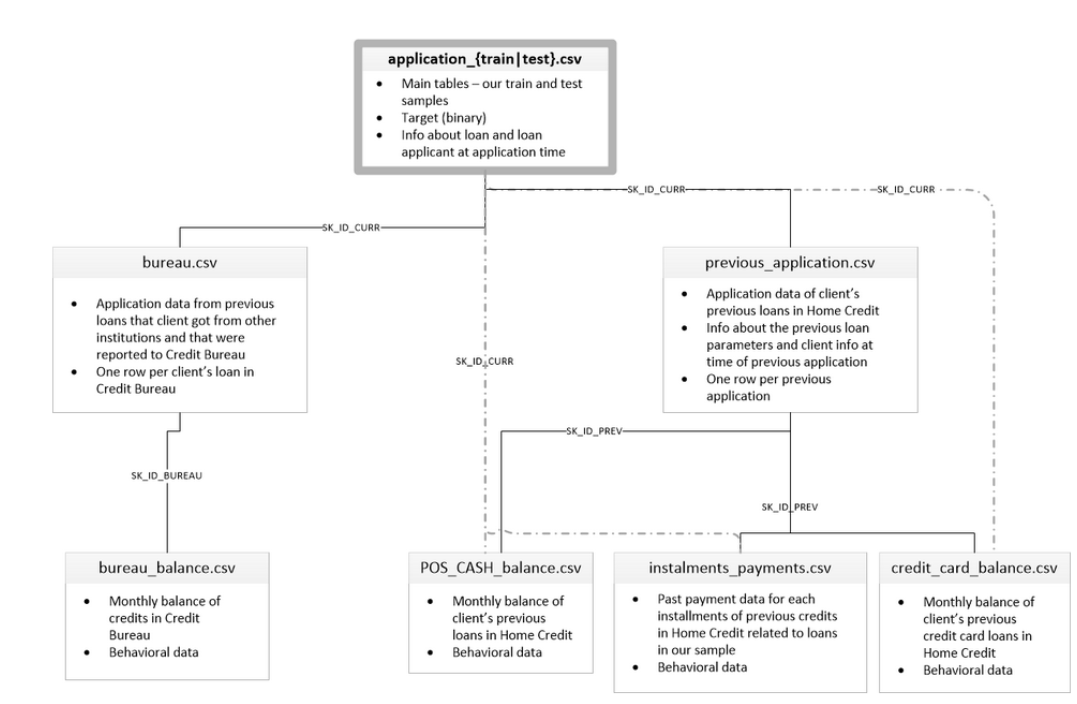

In [43]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [44]:
# Description des colonnes
pd.set_option("max_colwidth", 400)
HomeCredit_columns_description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


# Création d'un seul dataset à partir des différentes tables

In [45]:
# On ne garde que les informations les plus récentes
POS_CASH_balance_recent = POS_CASH_balance.loc[POS_CASH_balance['MONTHS_BALANCE'] == -1]
credit_card_balance_recent = credit_card_balance.loc[credit_card_balance['MONTHS_BALANCE'] == -1]

In [46]:
# Préparation du dataset préalable à une jointure
POS_CASH_balance2 = POS_CASH_balance_recent.groupby(['SK_ID_CURR']).apply(lambda x: pd.Series({
    'POS - Retard moyen de paiement en jours': x['SK_DPD'].mean(),
    'POS - Durée moyenne des crédits précédents':  x['CNT_INSTALMENT'].mean(),
    'POS - Nombre de mensualités restantes': x['CNT_INSTALMENT_FUTURE'].sum(),
    'POS - Montant des dettes restantes': x['SK_DPD_DEF'].sum(),
}))

In [47]:
# jointure POS_cash_balance
application_train = pd.merge(application_train, POS_CASH_balance2, how="left",on="SK_ID_CURR")

In [48]:
# Séparation en deux datasets bureaux, 1 dont le crédit est en cours et 1 dont le crédit est fini
bureau_actif = bureau.loc[bureau['CREDIT_ACTIVE'] == 'Active']
bureau_fini = bureau.loc[bureau['CREDIT_ACTIVE'] == 'Closed']

In [49]:
# Préparation du dataset préalable à une jointure
Bureau_actif = bureau_actif.groupby(by = 'SK_ID_CURR', as_index=False)['CREDIT_ACTIVE'].count()
Bureau_actif.columns = ['SK_ID_CURR', 'Nombre de crédits actifs']

Bureau_fini = bureau_fini.groupby(by = 'SK_ID_CURR', as_index=False)['CREDIT_ACTIVE'].count()
Bureau_fini.columns = ['SK_ID_CURR', 'Nombre de crédits remboursés']

In [50]:
# Première Jointure bureau
application_train = pd.merge(application_train, Bureau_actif, how = "left",on="SK_ID_CURR")
application_train = pd.merge(application_train, Bureau_fini, how = "left",on="SK_ID_CURR")

In [51]:
# Préparation du dataset préalable à une jointure
bureau2 = bureau.groupby(['SK_ID_CURR']).apply(lambda x: pd.Series({
    'bureau - Nombre de jours depuis la dernière demande': x['DAYS_CREDIT'].min(),
    'bureau - Nombre de fois ou le crédit a été prolongé':  x['CNT_CREDIT_PROLONG'].sum(),
    'bureau - Montant crédits en cours': x['AMT_CREDIT_SUM'].sum(),
    'bureau - Montant des dettes actuelles': x['AMT_CREDIT_SUM_DEBT'].sum(),
    'bureau - Montant actuel en souffrance': x['AMT_CREDIT_SUM_OVERDUE'].sum(),
}))

In [52]:
# 2e jointure bureau
application_train = pd.merge(application_train, bureau2, how = "left",on="SK_ID_CURR")

In [53]:
# Préparation du dataset préalable à une jointure

credit_card_balance2 = credit_card_balance_recent.groupby(['SK_ID_CURR']).apply(lambda x: pd.Series({
    'CB - Solde': x['AMT_BALANCE'].mean(),
    'CB - Limite':  x['AMT_CREDIT_LIMIT_ACTUAL'].mean(),
    'CB - Montant payé par le client': x['AMT_PAYMENT_TOTAL_CURRENT'].sum(),
    'CB - Nombre de retraits': x['CNT_DRAWINGS_ATM_CURRENT'].sum(),
}))

In [54]:
# Jointure credit card balance
application_train = pd.merge(application_train, credit_card_balance2, how = "left",on="SK_ID_CURR")

In [55]:
# Visualisation du nombre de lignes pour connaître le nombre de lignes supprimées
installments_payments.shape

(13605401, 8)

In [56]:
# On ne perd que très peu de lignes à supprimer les NaN
installments_payments_NoNaN = installments_payments.dropna()
installments_payments_NoNaN.shape

(13602496, 8)

In [57]:
# Préparation du dataset préalable à une jointure

installments_payments2 = installments_payments_NoNaN.groupby(['SK_ID_PREV']).apply(lambda x: pd.Series({
    'IP - Retard moyen des paiements': (x['DAYS_INSTALMENT'] - x['DAYS_ENTRY_PAYMENT']).mean(),
    'IP - Paiement en souffrance moyen':  (x['AMT_INSTALMENT'] - x['AMT_PAYMENT']).mean()
}))

In [58]:
# Jointure installments payments
previous_application = pd.merge(previous_application, installments_payments2, how="left",on="SK_ID_PREV")

In [59]:
# Préparation du dataset préalable à une jointure

previous_application2 = previous_application.groupby(['SK_ID_CURR']).apply(lambda x: pd.Series({
    'Previous - Montant demandé moyen': x['AMT_APPLICATION'].mean(),
    'Previous - Taux dinteret précédent moyen':  x['RATE_INTEREST_PRIMARY'].mean(),
    'IP - Retard moyen des paiements':  x['IP - Retard moyen des paiements'].mean(),
    'IP - Paiement en souffrance moyen':  x['IP - Paiement en souffrance moyen'].mean(),
}))

In [60]:
# Jointure previous application
application_train = pd.merge(application_train, previous_application2, how = "left",on="SK_ID_CURR")

In [61]:
application_train.shape

(307511, 141)

In [62]:
# Enregistrement du dataset première version
application_train.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7df1.csv')

In [63]:
application_train =pd.read_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7df1.csv')

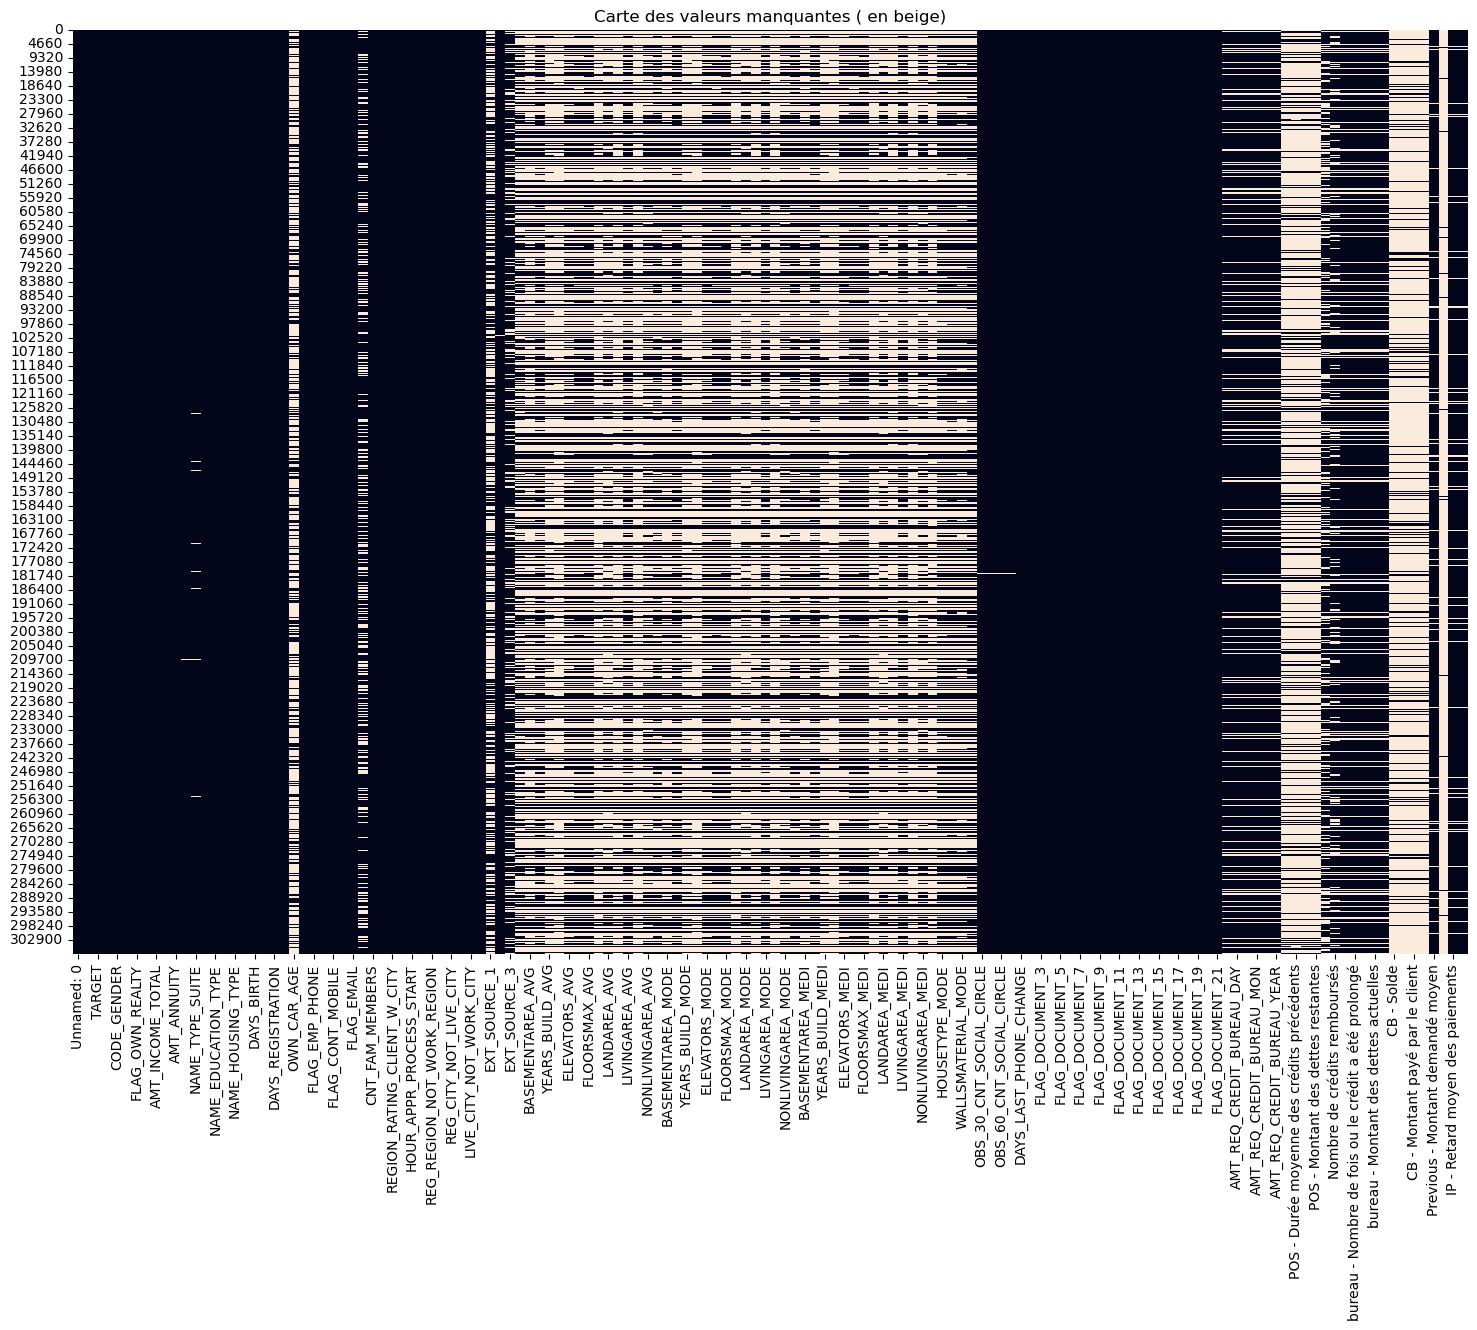

In [64]:
# Visualisation des données manquantes
plt.figure(figsize=(18,12))
heat_map = sns.heatmap(application_train.isnull(),cbar = False)
plt.title("Carte des valeurs manquantes ( en beige)")
plt.show()

In [65]:
#Recherche des valeurs nulles en pourcentage par colonne
(application_train.isna().sum() / application_train.shape[0])*100

Unnamed: 0                                              0.000000
SK_ID_CURR                                              0.000000
TARGET                                                  0.000000
NAME_CONTRACT_TYPE                                      0.000000
CODE_GENDER                                             0.000000
FLAG_OWN_CAR                                            0.000000
FLAG_OWN_REALTY                                         0.000000
CNT_CHILDREN                                            0.000000
AMT_INCOME_TOTAL                                        0.000000
AMT_CREDIT                                              0.000000
AMT_ANNUITY                                             0.003902
AMT_GOODS_PRICE                                         0.090403
NAME_TYPE_SUITE                                         0.420148
NAME_INCOME_TYPE                                        0.000000
NAME_EDUCATION_TYPE                                     0.000000
NAME_FAMILY_STATUS       

In [66]:
# Supprimons 50 colonnes dont il y a plus de 50% de NaN
nblignes = application_train.shape[0]
nbColInutiles = 0
df2 = application_train
for col in application_train.columns:
    if application_train[col].isnull().sum()/ nblignes >0.5 :
        df2 =df2.drop(col, axis=1)

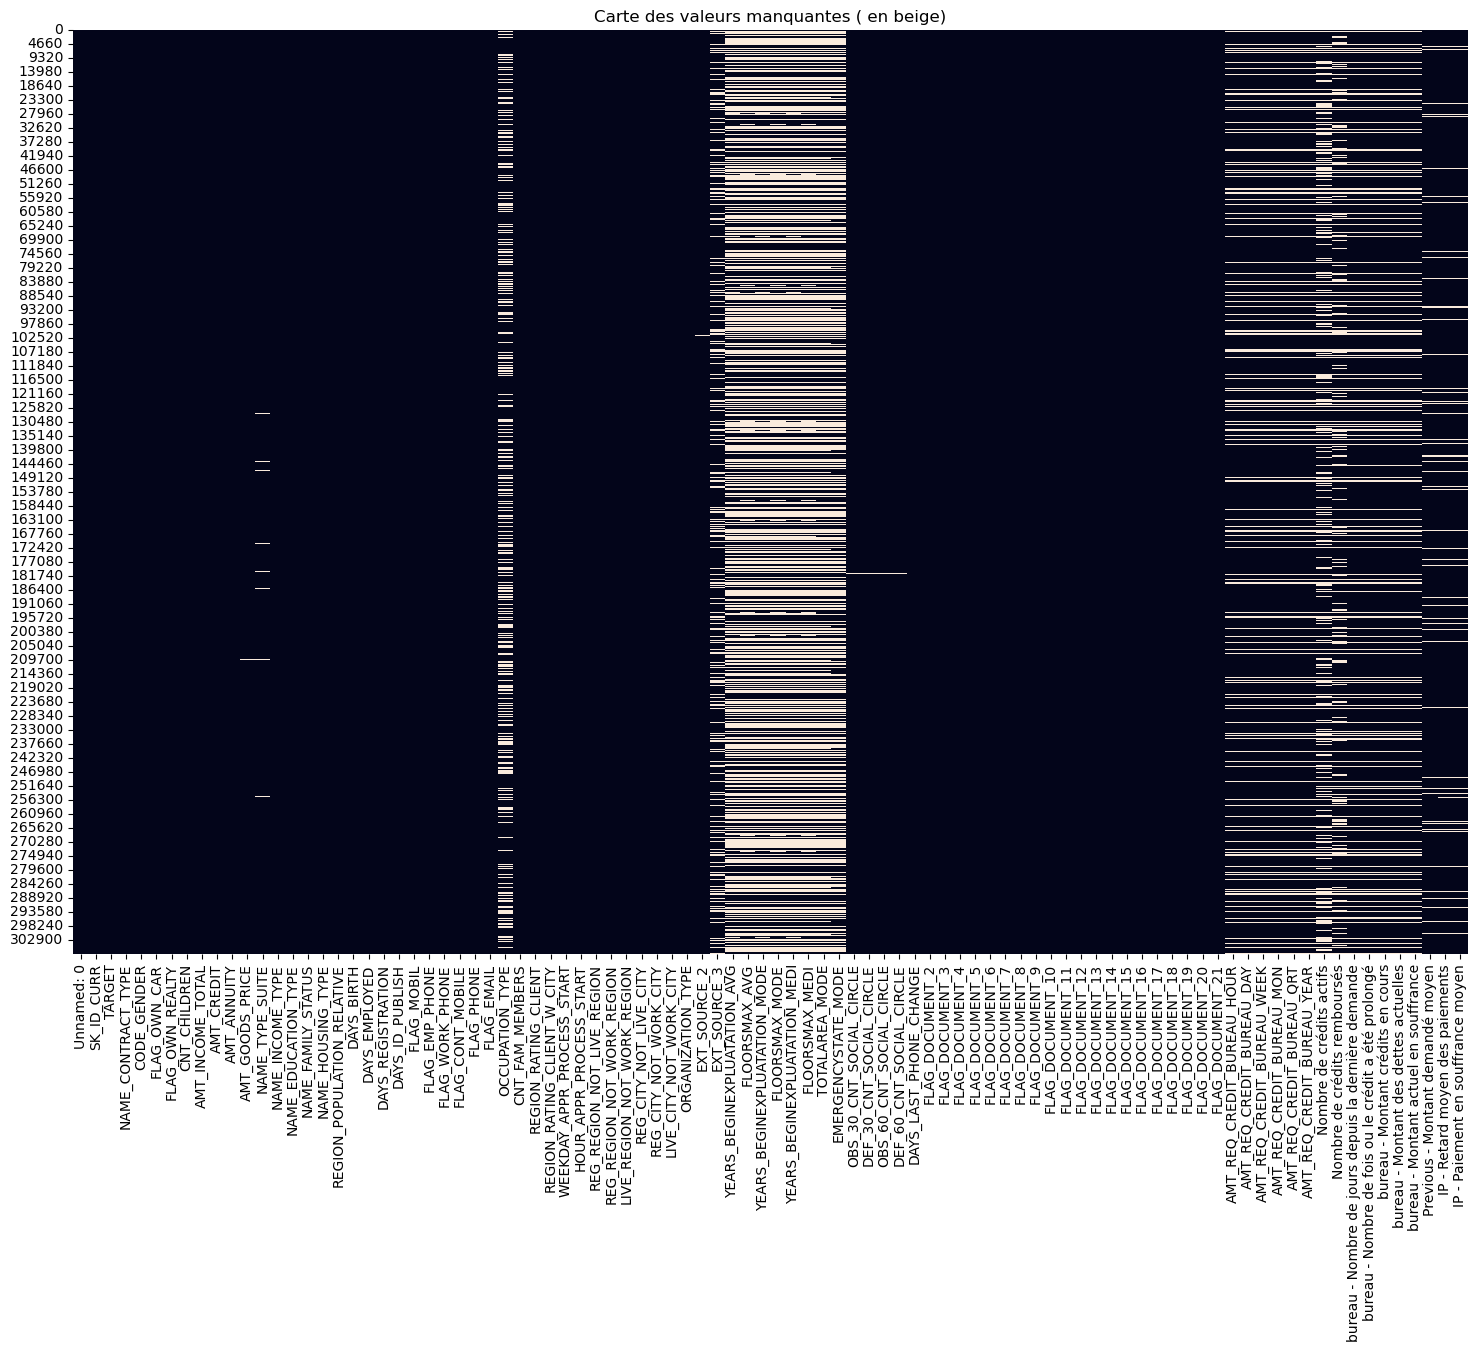

In [67]:
# Visualisation des données manquantes

plt.figure(figsize=(18,12))
heat_map = sns.heatmap(df2.isnull(),cbar = False)
plt.title("Carte des valeurs manquantes ( en beige)")
plt.show()

In [68]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 92 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   Unnamed: 0                                           307511 non-null  int64  
 1   SK_ID_CURR                                           307511 non-null  int64  
 2   TARGET                                               307511 non-null  int64  
 3   NAME_CONTRACT_TYPE                                   307511 non-null  object 
 4   CODE_GENDER                                          307511 non-null  object 
 5   FLAG_OWN_CAR                                         307511 non-null  object 
 6   FLAG_OWN_REALTY                                      307511 non-null  object 
 7   CNT_CHILDREN                                         307511 non-null  int64  
 8   AMT_INCOME_TOTAL                                     3

In [69]:
application_train = df2.copy()

In [70]:
# Chiffrage de données binaires textuelles
application_train['EMERGENCYSTATE_MODE'] = application_train['EMERGENCYSTATE_MODE'].replace(['No'], 0)
application_train['EMERGENCYSTATE_MODE'] = application_train['EMERGENCYSTATE_MODE'].replace(['Yes'], 1)
application_train['FLAG_OWN_REALTY'] = application_train['FLAG_OWN_REALTY'].replace(['N'], 0)
application_train['FLAG_OWN_REALTY'] = application_train['FLAG_OWN_REALTY'].replace(['Y'], 1)
application_train['FLAG_OWN_CAR'] = application_train['FLAG_OWN_CAR'].replace(['N'], 0)
application_train['FLAG_OWN_CAR'] = application_train['FLAG_OWN_CAR'].replace(['Y'], 1)
application_train['CODE_GENDER'] = application_train['CODE_GENDER'].replace(['M'], 0)
application_train['CODE_GENDER'] = application_train['CODE_GENDER'].replace(['F'], 1)
application_train['CODE_GENDER'] = application_train['CODE_GENDER'].apply(lambda x: x if x in [0, 1] else np.nan)

In [71]:
# Encodage en One Hot
one_hot_encoded_data = pd.get_dummies(application_train, columns = ['ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                                                                   'OCCUPATION_TYPE','NAME_HOUSING_TYPE',
                                                                   'NAME_FAMILY_STATUS','NAME_INCOME_TYPE',
                                                                   'NAME_TYPE_SUITE','NAME_CONTRACT_TYPE',
                                                                   'NAME_EDUCATION_TYPE',])
one_hot_encoded_data.drop(columns=['Unnamed: 0'], inplace=True)
one_hot_encoded_data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Nombre de crédits actifs,Nombre de crédits remboursés,bureau - Nombre de jours depuis la dernière demande,bureau - Nombre de fois ou le crédit a été prolongé,bureau - Montant crédits en cours,bureau - Montant des dettes actuelles,bureau - Montant actuel en souffrance,Previous - Montant demandé moyen,IP - Retard moyen des paiements,IP - Paiement en souffrance moyen,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION

In [72]:
one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 199 entries, SK_ID_CURR to NAME_EDUCATION_TYPE_Secondary / secondary special
dtypes: float64(39), int64(43), uint8(117)
memory usage: 226.7 MB


In [73]:
threshold = 0.1  # 10% threshold

# calcul du nombre de valeurs manquantes par colonne
missing_values = one_hot_encoded_data.isnull().sum()

# calcul du pourcentage de valeurs manquantes par colonne
percent_missing = missing_values / len(one_hot_encoded_data)

# sélection des colonnes avec au moins 10% de valeurs manquantes
selected_columns = percent_missing[percent_missing >= threshold].index

# sous-ensemble de données avec uniquement les colonnes sélectionnées
new_df = one_hot_encoded_data[selected_columns]

<Axes: >

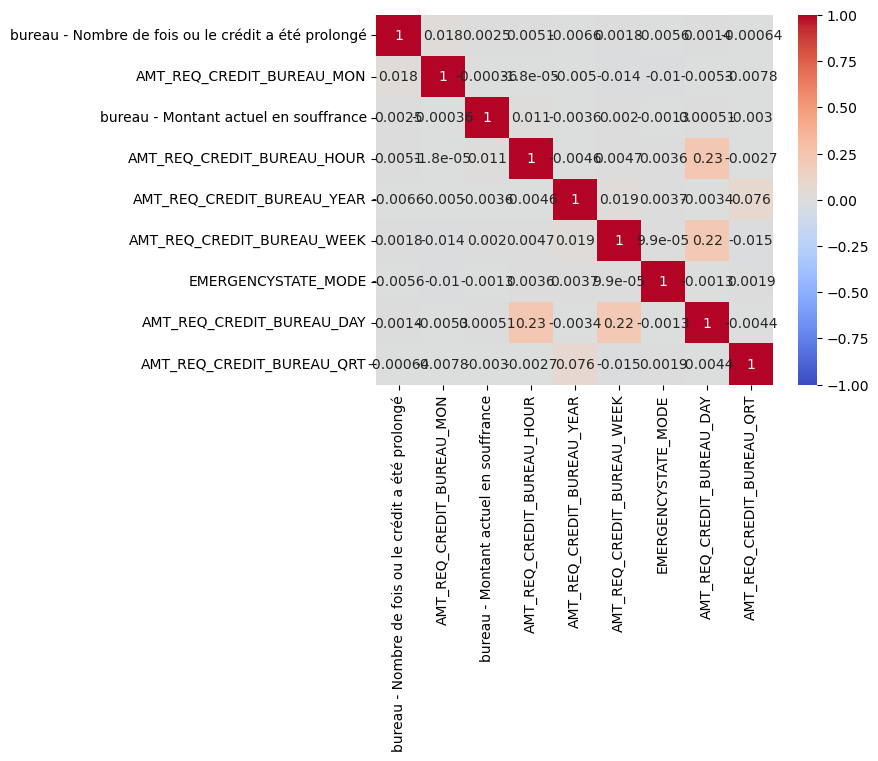

In [74]:
corr_matrix = new_df.corr().abs()
high_corr_var = np.where(corr_matrix > 0.25)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
low_corr_var = list(set(new_df.columns) - set(pd.DataFrame(high_corr_var).unstack().unique()))
df_low_corr = new_df[low_corr_var]
corr = df_low_corr.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)

In [75]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['bureau - Montant actuel en souffrance'].sort_values(ascending=False)
print(target_correlations)

bureau - Montant actuel en souffrance                  1.000000e+00
FLAG_WORK_PHONE                                        1.335525e-02
TARGET                                                 1.333475e-02
Nombre de crédits actifs                               1.245530e-02
OCCUPATION_TYPE_HR staff                               1.212381e-02
AMT_REQ_CREDIT_BUREAU_HOUR                             1.147426e-02
bureau - Montant des dettes actuelles                  1.076462e-02
FLAG_DOCUMENT_5                                        1.071129e-02
bureau - Montant crédits en cours                      8.667274e-03
REG_REGION_NOT_WORK_REGION                             8.423588e-03
FLAG_DOCUMENT_16                                       8.389805e-03
ORGANIZATION_TYPE_Industry: type 9                     6.793464e-03
NAME_EDUCATION_TYPE_Incomplete higher                  6.534573e-03
REG_REGION_NOT_LIVE_REGION                             5.863739e-03
TOTALAREA_MODE                                  

In [76]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['EMERGENCYSTATE_MODE'].sort_values(ascending=False)
print(target_correlations)

EMERGENCYSTATE_MODE                                    1.000000
REGION_RATING_CLIENT                                   0.038231
REGION_RATING_CLIENT_W_CITY                            0.034410
NAME_EDUCATION_TYPE_Secondary / secondary special      0.032352
NAME_HOUSING_TYPE_Municipal apartment                  0.029482
REG_CITY_NOT_LIVE_CITY                                 0.024295
NAME_INCOME_TYPE_Working                               0.021155
REG_CITY_NOT_WORK_CITY                                 0.019264
bureau - Nombre de jours depuis la dernière demande    0.013350
TARGET                                                 0.012201
LIVE_CITY_NOT_WORK_CITY                                0.011691
CNT_CHILDREN                                           0.011202
DAYS_ID_PUBLISH                                        0.011055
OCCUPATION_TYPE_Laborers                               0.010678
FLAG_DOCUMENT_3                                        0.009958
DAYS_BIRTH                              

In [77]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['bureau - Nombre de fois ou le crédit a été prolongé'].sort_values(ascending=False)
print(target_correlations)

bureau - Nombre de fois ou le crédit a été prolongé    1.000000
Nombre de crédits actifs                               0.102248
Nombre de crédits remboursés                           0.082001
ORGANIZATION_TYPE_Transport: type 2                    0.074904
bureau - Montant crédits en cours                      0.056238
FLAG_EMP_PHONE                                         0.036863
NAME_EDUCATION_TYPE_Higher education                   0.031600
bureau - Montant des dettes actuelles                  0.028963
DAYS_BIRTH                                             0.021987
AMT_GOODS_PRICE                                        0.020950
AMT_CREDIT                                             0.020615
Previous - Montant demandé moyen                       0.020222
OCCUPATION_TYPE_Managers                               0.019472
AMT_REQ_CREDIT_BUREAU_MON                              0.017733
TOTALAREA_MODE                                         0.017628
AMT_INCOME_TOTAL                        

In [78]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_MON'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_MON                              1.000000
Nombre de crédits remboursés                           0.136710
REGION_POPULATION_RELATIVE                             0.078607
Nombre de crédits actifs                               0.078495
bureau - Montant crédits en cours                      0.067481
AMT_GOODS_PRICE                                        0.056422
AMT_CREDIT                                             0.054451
EXT_SOURCE_2                                           0.051981
NAME_INCOME_TYPE_Commercial associate                  0.046776
FLOORSMAX_AVG                                          0.046762
FLOORSMAX_MEDI                                         0.045992
Previous - Montant demandé moyen                       0.045919
FLOORSMAX_MODE                                         0.044121
bureau - Montant des dettes actuelles                  0.042123
AMT_ANNUITY                                            0.039148
HOUR_APPR_PROCESS_START                 

In [79]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_QRT'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_QRT                              1.000000
AMT_REQ_CREDIT_BUREAU_YEAR                             0.076208
NAME_CONTRACT_TYPE_Cash loans                          0.021962
AMT_GOODS_PRICE                                        0.016432
AMT_CREDIT                                             0.015925
FLAG_OWN_REALTY                                        0.015451
DAYS_EMPLOYED                                          0.015345
ORGANIZATION_TYPE_XNA                                  0.015252
NAME_INCOME_TYPE_Pensioner                             0.015239
FLAG_EMAIL                                             0.013426
Previous - Montant demandé moyen                       0.012378
FLAG_DOCUMENT_6                                        0.010201
AMT_ANNUITY                                            0.010124
FLAG_DOCUMENT_3                                        0.009576
Nombre de crédits remboursés                           0.008613
ORGANIZATION_TYPE_Self-employed         

In [80]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_HOUR'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_HOUR                             1.000000
AMT_REQ_CREDIT_BUREAU_DAY                              0.230374
WEEKDAY_APPR_PROCESS_START_SUNDAY                      0.018005
FLAG_DOCUMENT_12                                       0.016142
bureau - Montant crédits en cours                      0.015300
bureau - Montant actuel en souffrance                  0.011474
WEEKDAY_APPR_PROCESS_START_SATURDAY                    0.010726
NAME_INCOME_TYPE_State servant                         0.008973
bureau - Montant des dettes actuelles                  0.006867
NAME_EDUCATION_TYPE_Incomplete higher                  0.006833
REGION_RATING_CLIENT                                   0.006312
REGION_RATING_CLIENT_W_CITY                            0.006239
ORGANIZATION_TYPE_Other                                0.005607
DAYS_BIRTH                                             0.005285
bureau - Nombre de fois ou le crédit a été prolongé    0.005059
FLAG_DOCUMENT_8                         

In [81]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_WEEK'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_WEEK                             1.000000
AMT_REQ_CREDIT_BUREAU_DAY                              0.217412
FLAG_EMAIL                                             0.021581
AMT_REQ_CREDIT_BUREAU_YEAR                             0.018917
NAME_CONTRACT_TYPE_Cash loans                          0.015296
Nombre de crédits actifs                               0.015155
AMT_ANNUITY                                            0.013881
Nombre de crédits remboursés                           0.009734
FLAG_DOCUMENT_3                                        0.008175
FLAG_OWN_REALTY                                        0.007474
ORGANIZATION_TYPE_Trade: type 6                        0.006451
AMT_REQ_CREDIT_BUREAU_HOUR                             0.004706
NAME_TYPE_SUITE_Unaccompanied                          0.004695
WEEKDAY_APPR_PROCESS_START_FRIDAY                      0.004613
ORGANIZATION_TYPE_Postal                               0.004586
NAME_HOUSING_TYPE_House / apartment     

In [82]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_YEAR'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_YEAR                             1.000000
Previous - Montant demandé moyen                       0.168599
AMT_REQ_CREDIT_BUREAU_QRT                              0.076208
FLAG_OWN_REALTY                                        0.067451
NAME_EDUCATION_TYPE_Secondary / secondary special      0.065976
FLAG_EMAIL                                             0.053354
NAME_CONTRACT_TYPE_Cash loans                          0.052494
NAME_INCOME_TYPE_Pensioner                             0.050085
ORGANIZATION_TYPE_XNA                                  0.050001
DAYS_EMPLOYED                                          0.049988
FLAG_DOCUMENT_3                                        0.048214
Nombre de crédits remboursés                           0.036631
OBS_60_CNT_SOCIAL_CIRCLE                               0.032957
OBS_30_CNT_SOCIAL_CIRCLE                               0.032567
Nombre de crédits actifs                               0.029449
FLAG_CONT_MOBILE                        

In [83]:
# Calculer les corrélations
correlations = one_hot_encoded_data.corr()
# Corrélations avec la variable cible
target_correlations = correlations['AMT_REQ_CREDIT_BUREAU_DAY'].sort_values(ascending=False)
print(target_correlations)

AMT_REQ_CREDIT_BUREAU_DAY                              1.000000
AMT_REQ_CREDIT_BUREAU_HOUR                             0.230374
AMT_REQ_CREDIT_BUREAU_WEEK                             0.217412
FLAG_DOCUMENT_18                                       0.013281
FLAG_DOCUMENT_14                                       0.013119
FLAG_DOCUMENT_12                                       0.012206
TOTALAREA_MODE                                         0.010730
ORGANIZATION_TYPE_Trade: type 6                        0.008293
FLAG_DOCUMENT_13                                       0.007012
WEEKDAY_APPR_PROCESS_START_THURSDAY                    0.006331
FLAG_DOCUMENT_16                                       0.006318
ORGANIZATION_TYPE_Industry: type 3                     0.006284
Nombre de crédits actifs                               0.005767
NAME_CONTRACT_TYPE_Cash loans                          0.005118
AMT_GOODS_PRICE                                        0.004677
NAME_INCOME_TYPE_State servant          

In [84]:
# Suppression des colonnes sans corrélation afin d'utiliser Iterative Imputer
one_hot_encoded_data.drop(columns=['AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_WEEK',
                                  'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_QRT',
                                  'AMT_REQ_CREDIT_BUREAU_MON','bureau - Nombre de fois ou le crédit a été prolongé',
                                  'EMERGENCYSTATE_MODE','bureau - Montant actuel en souffrance'], inplace=True)

In [ ]:
# Imputation des données manquantes avec IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp=IterativeImputer()
imputed = imp.fit_transform(one_hot_encoded_data)
df_imputed = pd.DataFrame(imputed, columns = one_hot_encoded_data.columns)

In [ ]:
(df_imputed.isna().sum()/df_imputed.shape[0])*100

In [ ]:
df_imputed.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7df2.csv')

# Possibilité de Data Leakage

In [85]:
# Import des données
df =pd.read_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7df2.csv')

In [86]:
# Calculer les corrélations
correlations = df.corr()
# Corrélations avec la variable cible
target_correlations = correlations['TARGET'].sort_values(ascending=False)
print(target_correlations)

TARGET                                                 1.000000
bureau - Nombre de jours depuis la dernière demande    0.083263
DAYS_BIRTH                                             0.078239
Nombre de crédits actifs                               0.074147
REGION_RATING_CLIENT_W_CITY                            0.060893
REGION_RATING_CLIENT                                   0.058899
NAME_INCOME_TYPE_Working                               0.057481
DAYS_LAST_PHONE_CHANGE                                 0.055217
DAYS_ID_PUBLISH                                        0.051457
REG_CITY_NOT_WORK_CITY                                 0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special      0.049824
FLAG_EMP_PHONE                                         0.045982
REG_CITY_NOT_LIVE_CITY                                 0.044395
FLAG_DOCUMENT_3                                        0.044346
OCCUPATION_TYPE_Laborers                               0.043019
DAYS_REGISTRATION                       

In [87]:
# Il n'y a aucun problème de Data Leakage

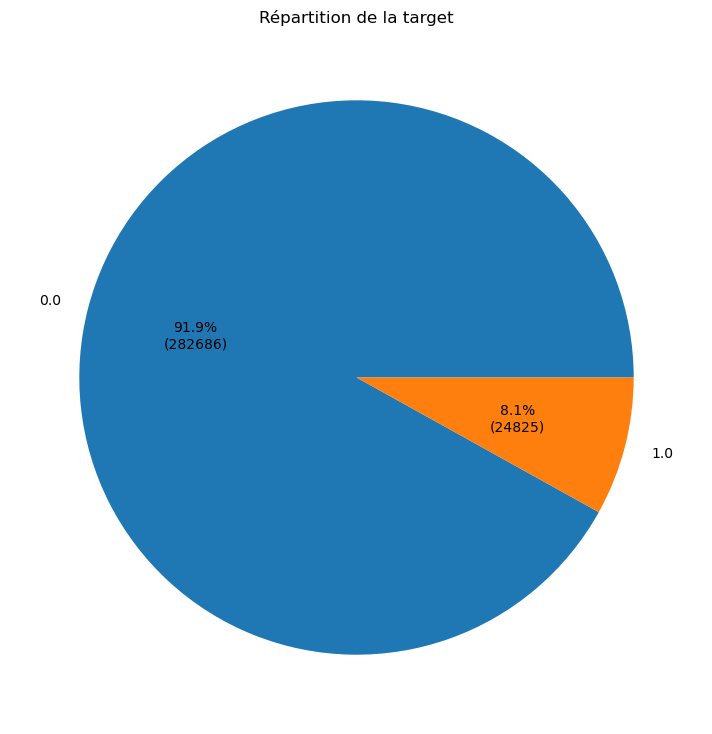

In [88]:
# Définition de la fonction Pie Chart
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format
    
s = df['TARGET'].value_counts()
plt.figure(figsize=(15,9))
plt.pie(s,labels = s.index, autopct=autopct_format(s))
plt.title('Répartition de la target')
plt.show()

# SMOTE pour équilibrer le dataset

In [89]:
from sklearn.model_selection import train_test_split
y = df['TARGET']
X = df.drop('TARGET', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [90]:
# Nous équilibrons le dataset uniquement sur le jeu d'entraînement pour avoir un jeu de test "pur"
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

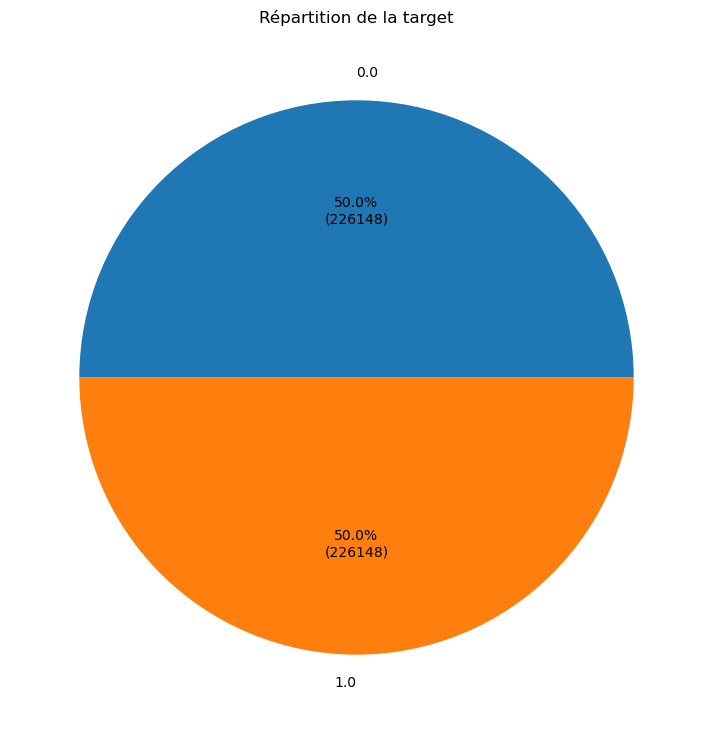

In [91]:
# Visualisation de la répartition des target après équilibrage
s = y_train.value_counts()
plt.figure(figsize=(15,9))
plt.pie(s,labels = s.index, autopct=autopct_format(s))
plt.title('Répartition de la target')
plt.show()

In [ ]:
X_train.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_X_train.csv')
X_test.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_X_test.csv')
y_train.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_y_train.csv')
y_test.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_y_test.csv')

# Modélisation

In [1]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle
import shap
import mlflow
import mlflow.sklearn

In [4]:
# Import des données
X_train = pd.read_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_X_train.csv')
X_test = pd.read_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_X_test.csv')
y_train = pd.read_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_y_train.csv')
y_test = pd.read_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_y_test.csv')

y_test.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0','Unnamed: 0.2','Unnamed: 0.1','SK_ID_CURR'], inplace=True)
X_test.drop(columns=['Unnamed: 0','Unnamed: 0.2','Unnamed: 0.1','SK_ID_CURR'], inplace=True)


# Mettre à l'échelle les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn import metrics
import time
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
from sklearn.feature_selection import RFECV

# Définition de la fonction coût

Nous partons du principe suggéré dans l'énoncé qu'un faux négatif coûte 10 fois moins cher qu'un faux positif.  
nous allons donc essayer de minimiser au maximum cette perte dans note fonction coût

In [8]:
def custom_cost(y_true, y_pred):
    # Coûts des faux positifs et faux négatifs
    y_true = np.array(y_true)
    false_positive_cost = np.int64(1)
    false_negative_cost = np.int64(10)

    # Calcul des faux positifs et faux négatifs en suivant les prédictions de l'algorithme
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût total moyen
    total_cost = (fp * false_positive_cost) + (fn * false_negative_cost)
   # average_cost = total_cost / (false_positives + false_negatives)
    Cost = total_cost/100
    
    return Cost
custom_scorer = make_scorer(custom_cost, greater_is_better=False)

In [9]:
# Définition de la fonction permettant d'afficher des métriques
def plot_confusion_roc(y_true, y_pred):
    # Print l'accuracy
    print('accuracy test:',round(metrics.accuracy_score(y_test, y_pred),2))
    # Calculer l'AUC
    auc = roc_auc_score(y_true, y_pred)

    # Afficher l'AUC
    print("AUC:", auc)
    
    # Afficher le score
    print('Score métier test : ', round(custom_cost(y_true, y_pred),2))
    
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)

    # Calculer les valeurs nécessaires pour la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    # Tracer la matrice de confusion
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Valeur réelle')

    # Tracer la courbe ROC
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label='Courbe ROC (AUC = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()
    
#Définition de la fonction recherchant le seuil optimal
def find_optimal_threshold(model, X, y, false_positive_cost=1, false_negative_cost=10):
    probabilities = model.predict_proba(X)[:, 1]
    thresholds = np.arange(0, 1.01, 0.01)
    costs = []  # Liste des coûts

    for threshold in thresholds:
        predictions = (probabilities >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
        total_cost = fp * false_positive_cost + fn * false_negative_cost
        costs.append(total_cost)

    return thresholds[np.argmin(costs)]  # Renvoie le seuil qui minimise le coût


# Définition de la fonction donnant des prédictions en utilisant le seuil
def predict_with_threshold(model, X, threshold):

    probabilities = model.predict_proba(X)[:, 1]

    predictions = (probabilities >= threshold).astype(int)

    return predictions

# Essais de différentes modélisations

## DummyClassifier

temps d execution :  0.051061153411865234
accuracy train : 0.5
accuracy test: 0.92
AUC: 0.5
Score métier test :  496.5


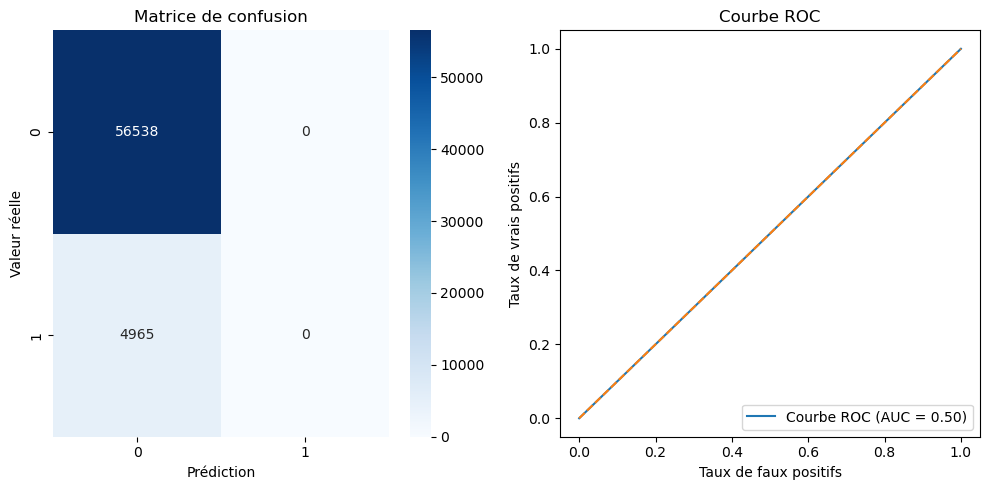

Setuptools is replacing distutils.


In [11]:
mlflow.set_experiment('Projet7-Modélisation')
start = time.time()
with mlflow.start_run(run_name='DummyClassifier') :
    model = DummyClassifier()
    model.fit(X_train_scaled_df, y_train)
    y_pred_train = model.predict(X_train_scaled_df)
    y_pred = model.predict(X_test_scaled_df)
    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :',round(metrics.accuracy_score(y_train, y_pred_train),2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'Dummy')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )

## Régression logistique

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


temps d execution :  73.63631701469421
accuracy train : 0.72
accuracy test: 0.71
AUC: 0.6996258538625306
Score métier test :  318.12


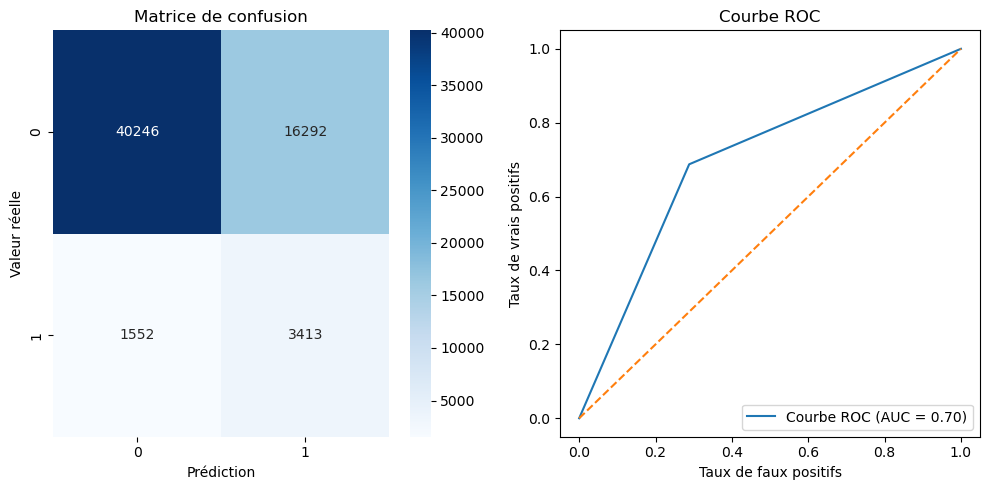

In [21]:
mlflow.set_experiment('Projet7-Modélisation')

start = time.time()

with mlflow.start_run(run_name='Régression logistique') :
    # Création du modèle de régression logistique
    model = LogisticRegression(max_iter = 2000)

    # Définition de la fonction de coût personnalisée comme la métrique à minimiser
    model.fit(X_train_scaled_df, y_train)
    y_pred_train = model.predict(X_train_scaled_df)
    y_pred = model.predict(X_test_scaled_df)
    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :',round(metrics.accuracy_score(y_train, y_pred_train),2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'Regression Logistique')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )

In [26]:
# Définir les hyperparamètres et leurs distributions à échantillonner
param_dist = {'C': [0.01, 0.1, 1, 10, 100]}

# Créer le modèle de régression logistique
model = LogisticRegression(solver = 'liblinear', max_iter = 2000)

# Créer l'objet RandomizedSearchCV avec votre fonction de coût personnalisée
random_search = RandomizedSearchCV(model, param_distributions = param_dist, scoring = custom_scorer, cv = 5, n_iter = 5)

# Effectuer la recherche aléatoire des meilleurs paramètres
random_search.fit(X_train, y_train.values.ravel())

# Obtenir les meilleurs paramètres et le meilleur score
best_params = random_search.best_params_
best_score = random_search.best_score_
print ('Meilleurs paramètres : ', best_params)
print ('Meilleur score : ', best_score)

Meilleurs paramètres :  {'C': 0.01}
Meilleur score :  -2107.484


temps d execution :  16.224392890930176
accuracy train : 0.6
accuracy test: 0.62
AUC: 0.5972443205590999
Score métier test :  426.12


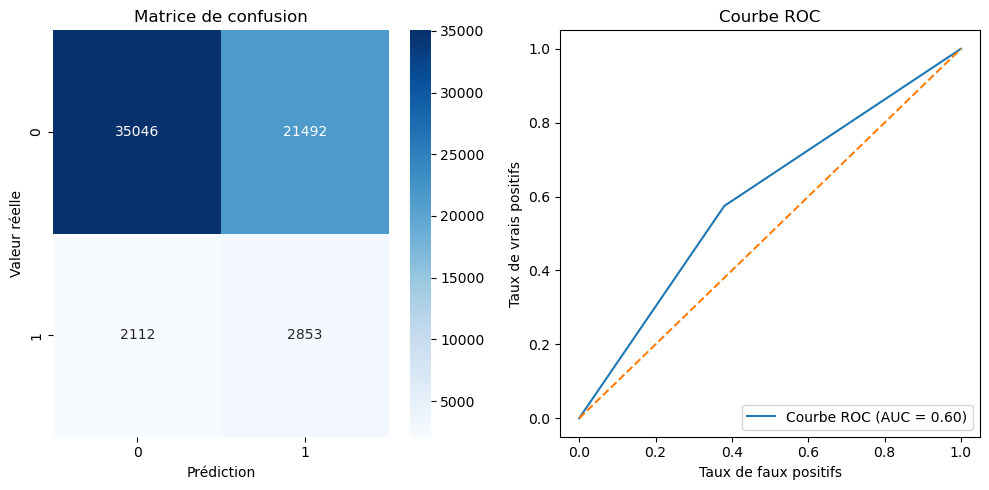

In [28]:
mlflow.set_experiment('Projet7-Modélisation')

# Entraînement du modèle paramétré
start = time.time()
with mlflow.start_run(run_name='Régression logistique paramétrée') :
    # Création du modèle de régression logistique
    model = LogisticRegression(solver = 'liblinear', max_iter = 2000, C = 0.01)

    # Définition de la fonction de coût personnalisée comme la métrique à minimiser
    model.fit(X_train, y_train.values.ravel())
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'Regression Logistique paramétrée')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )
    mlflow.log_param("C", 0.01)
    mlflow.log_param("Max_iter", 2000)

## LightGBM

In [6]:
# Enelever les caractères spéciaux dans les noms de colonne bloquant le LightGBM
import re
import pandas as pd


# Fonction pour supprimer les caractères spéciaux des noms de colonnes
def remove_special_characters(column_name):
    return re.sub('[^A-Za-z0-9]+', '', column_name)

# Renomme les colonnes en utilisant la fonction remove_special_characters
X_train = X_train.rename(columns=remove_special_characters)
X_test = X_test.rename(columns=remove_special_characters)



temps d execution :  5.544715404510498
accuracy train : 0.96
accuracy test: 0.93
AUC: 0.5806099076855403
Score métier test :  416.67


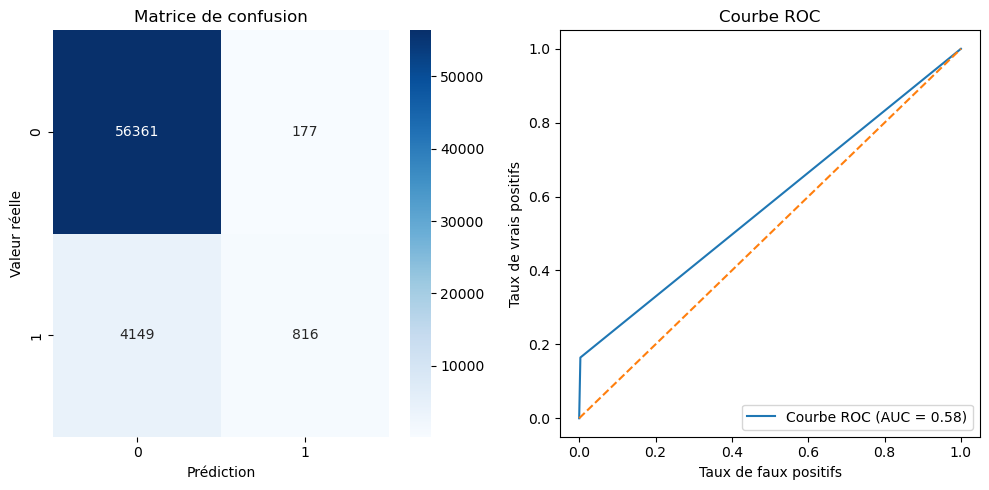

Setuptools is replacing distutils.


In [8]:
mlflow.set_experiment('Projet7-Modélisation')
start = time.time()
with mlflow.start_run(run_name='LightGBM') :
    # Création du modèle de LGBM
    model = lgb.LGBMClassifier()

    # Définition de la fonction de coût personnalisée comme la métrique à minimiser
    model.fit(X_train, y_train.values.ravel())
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'LightGBM')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )

In [9]:
# Feature engineering
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
# Obtention des importances des fonctionnalités
importances = model.feature_importances_

# Création d'un DataFrame pour stocker les noms de colonnes et les importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Tri du DataFrame selon les importances
sorted_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Affichage des noms de colonnes et des importances
print(sorted_importances)


                                        Feature  Importance
63                         Nombredecrditsactifs         310
34                                FLOORSMAXMODE         263
30                                   EXTSOURCE3         219
35                   YEARSBEGINEXPLUATATIONMEDI         135
64                      Nombredecrditsrembourss         134
29                                   EXTSOURCE2         111
38                         OBS30CNTSOCIALCIRCLE         107
67              bureauMontantdesdettesactuelles          99
0                                    CODEGENDER          97
27                           REGCITYNOTWORKCITY          92
161                     NAMEFAMILYSTATUSMarried          70
9                                     DAYSBIRTH          68
1                                    FLAGOWNCAR          58
17                                    FLAGPHONE          56
21                      REGIONRATINGCLIENTWCITY          53
180                  NAMETYPESUITEUnacco

In [10]:

# Créer une série pandas avec les noms de colonnes et leurs importances
feature_importances = pd.Series(importances, index=X_train.columns)

# Trier les fonctionnalités par ordre décroissant d'importance
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Afficher les noms de colonnes et leurs importances
print(sorted_feature_importances)

# Définir un seuil d'importance (à ajuster en fonction de vos besoins)
threshold = 2

# Sélectionner les colonnes dont l'importance est supérieure ou égale au seuil
selected_columns = sorted_feature_importances[sorted_feature_importances >= threshold].index

# Supprimer les colonnes non sélectionnées de vos données
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]


Nombredecrditsactifs                          310
FLOORSMAXMODE                                 263
EXTSOURCE3                                    219
YEARSBEGINEXPLUATATIONMEDI                    135
Nombredecrditsrembourss                       134
EXTSOURCE2                                    111
OBS30CNTSOCIALCIRCLE                          107
bureauMontantdesdettesactuelles                99
CODEGENDER                                     97
REGCITYNOTWORKCITY                             92
NAMEFAMILYSTATUSMarried                        70
DAYSBIRTH                                      68
FLAGOWNCAR                                     58
FLAGPHONE                                      56
REGIONRATINGCLIENTWCITY                        53
NAMETYPESUITEUnaccompanied                     45
YEARSBEGINEXPLUATATIONAVG                      44
FLAGOWNREALTY                                  43
AMTANNUITY                                     42
ORGANIZATIONTYPESelfemployed                   40


In [11]:
pd.set_option('display.max_columns', None)
print(X_train_selected.columns.tolist())

['Nombredecrditsactifs', 'FLOORSMAXMODE', 'EXTSOURCE3', 'YEARSBEGINEXPLUATATIONMEDI', 'Nombredecrditsrembourss', 'EXTSOURCE2', 'OBS30CNTSOCIALCIRCLE', 'bureauMontantdesdettesactuelles', 'CODEGENDER', 'REGCITYNOTWORKCITY', 'NAMEFAMILYSTATUSMarried', 'DAYSBIRTH', 'FLAGOWNCAR', 'FLAGPHONE', 'REGIONRATINGCLIENTWCITY', 'NAMETYPESUITEUnaccompanied', 'YEARSBEGINEXPLUATATIONAVG', 'FLAGOWNREALTY', 'AMTANNUITY', 'ORGANIZATIONTYPESelfemployed', 'FLAGDOCUMENT3', 'bureauNombredejoursdepuisladerniredemande', 'AMTGOODSPRICE', 'NAMEINCOMETYPEWorking', 'AMTCREDIT', 'REGIONRATINGCLIENT', 'DAYSEMPLOYED', 'IPPaiementensouffrancemoyen', 'NAMEEDUCATIONTYPESecondarysecondaryspecial', 'DAYSREGISTRATION', 'YEARSBEGINEXPLUATATIONMODE', 'DAYSLASTPHONECHANGE', 'NAMECONTRACTTYPECashloans', 'CNTCHILDREN', 'TOTALAREAMODE', 'OCCUPATIONTYPELaborers', 'ORGANIZATIONTYPEBusinessEntityType3', 'REGCITYNOTLIVECITY', 'FLOORSMAXMEDI', 'NAMEEDUCATIONTYPEHighereducation', 'NAMEFAMILYSTATUSSinglenotmarried', 'DAYSIDPUBLISH', 'WE

temps d execution :  3.9875173568725586
accuracy train : 0.96
accuracy test: 0.93
AUC: 0.5800675833455434
Score métier test :  417.2


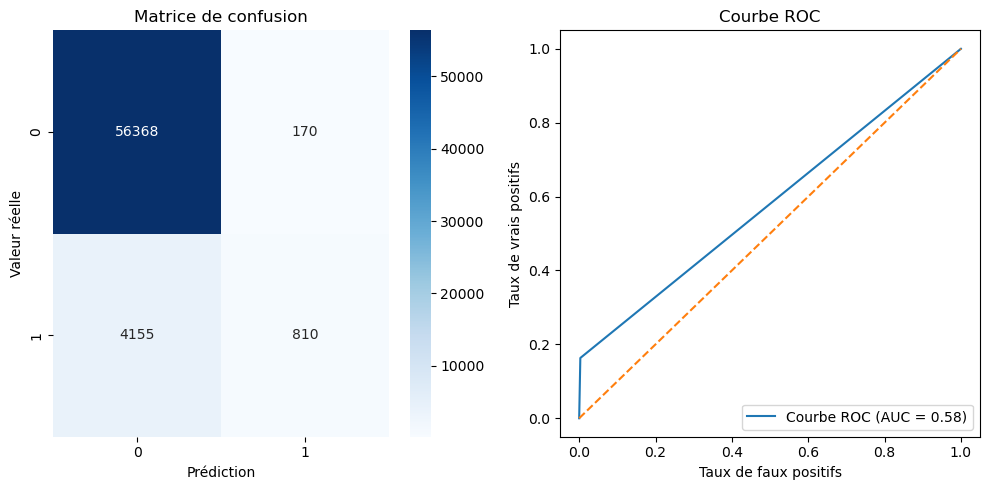

In [34]:
mlflow.set_experiment('Projet7-Modélisation')
start = time.time()
with mlflow.start_run(run_name='LightGBM feature selected') :
    # Création du modèle de LGBM
    model = lgb.LGBMClassifier()

    # Définition de la fonction de coût personnalisée comme la métrique à minimiser
    model.fit(X_train_selected, y_train.values.ravel())
    y_pred_train = model.predict(X_train_selected)
    y_pred = model.predict(X_test_selected)

    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'LightGBM Feature selected')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )

In [36]:
from scipy.stats import randint as sp_randint
# Définition du modèle LightGBM
model = lgb.LGBMClassifier()

# Définition de la grille de recherche
param_grid = {
    'n_estimators': sp_randint(200, 800),
    'max_depth': sp_randint(3, 8),
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Définition de RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid,scoring = custom_scorer, n_iter=10, cv=5, random_state=42)

# Lancement de la recherche aléatoire des hyperparamètres
random_search.fit(X_train_selected, y_train.values.ravel())

# Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres :")
print(random_search.best_params_)

# Affichage des résultats par fold
cv_results = random_search.cv_results_
for fold_idx, mean_score, params in zip(cv_results['split0_test_score'], cv_results['mean_test_score'], cv_results['params']):
    print("Fold:", fold_idx)
    print("Mean Score:", mean_score)
    print("Parameters:", params)
    print()

Meilleurs hyperparamètres :
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 515, 'subsample': 0.9}
Fold: -1988.2
Mean Score: -403.356
Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 271, 'subsample': 0.8}

Fold: -1985.9
Mean Score: -400.968
Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 666, 'subsample': 1.0}

Fold: -1985.9
Mean Score: -401.28
Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 299, 'subsample': 1.0}

Fold: -1987.0
Mean Score: -402.286
Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 543, 'subsample': 0.9}

Fold: -1985.9
Mean Score: -400.58000000000004
Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 476, 'subsample': 0.8}

Fold: -1985.8
Mean Score: -400.77
Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_dep

temps d execution :  12.291207790374756
accuracy train : 0.97
accuracy test: 0.93
AUC: 0.6153274502756694
Score métier test :  382.31


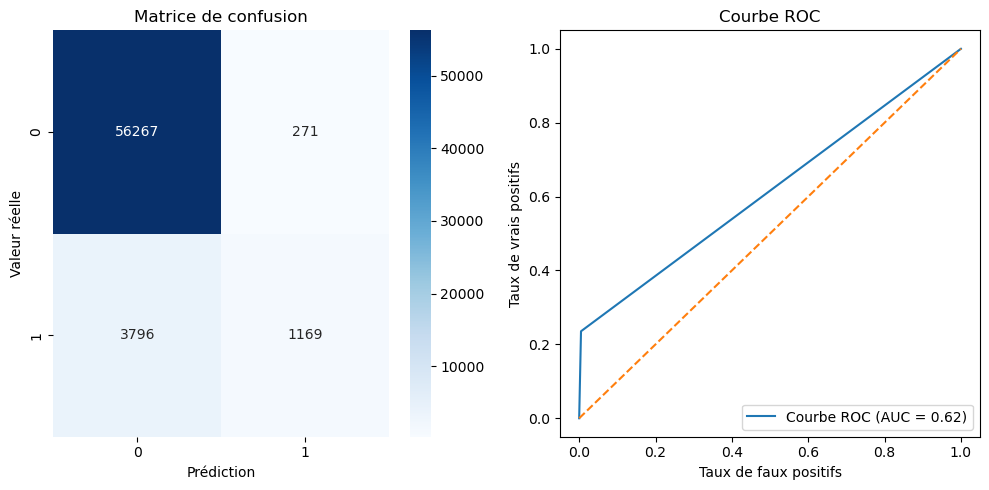

In [37]:
mlflow.set_experiment('Projet7-Modélisation')
start = time.time()
with mlflow.start_run(run_name='LightGBM feature selected paramétrée') :
    # Création du modèle de LGBM
    model = lgb.LGBMClassifier(n_estimators = 515,max_depth = 6,learning_rate = 0.1,subsample = 0.9,colsample_bytree= 0.9 )

    # Définition de la fonction de coût personnalisée comme la métrique à minimiser
    model.fit(X_train_selected, y_train.values.ravel())
    y_pred_train = model.predict(X_train_selected)
    y_pred = model.predict(X_test_selected)

    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'LightGBM feature selected paramétrée')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )
    mlflow.log_param("n_estimator", 515)
    mlflow.log_param("Max_depth", 6)
    mlflow.log_param("Learning rate", 0.1)
    mlflow.log_param("Subsample", 0.9)
    mlflow.log_param("Colsample_bytree", 0.9)

seuil optimal :  0.11
accuracy train : 0.93
accuracy test: 0.84
AUC: 0.7795129100135203
Score métier test :  228.98


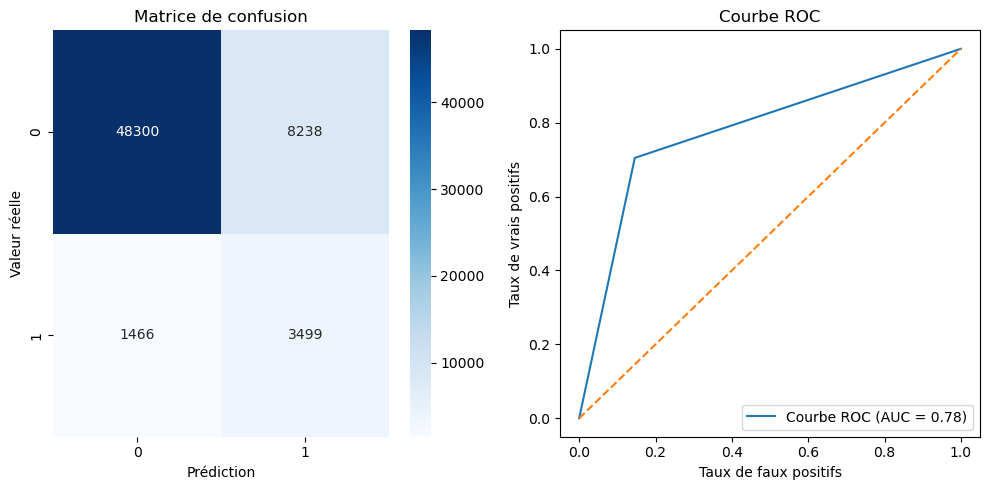

In [12]:
model = lgb.LGBMClassifier(n_estimators = 515,max_depth = 6,learning_rate = 0.1,subsample = 0.9,colsample_bytree= 0.9 )
model.fit(X_train_selected, y_train.values.ravel())
# Convertir y_train en une série
y_train_series = y_train.squeeze()

seuil_optimal = find_optimal_threshold(model, X_train_selected, y_train_series)
print('seuil optimal : ',seuil_optimal)
y_pred_train = predict_with_threshold(model, X_train_selected, seuil_optimal)
y_pred = predict_with_threshold(model, X_test_selected, seuil_optimal)
print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
plot_confusion_roc(y_test, y_pred)

seuil optimal :  0.11
temps d execution :  47.22891116142273
accuracy train : 0.93
accuracy test: 0.84
AUC: 0.7795129100135203
Score métier test :  228.98


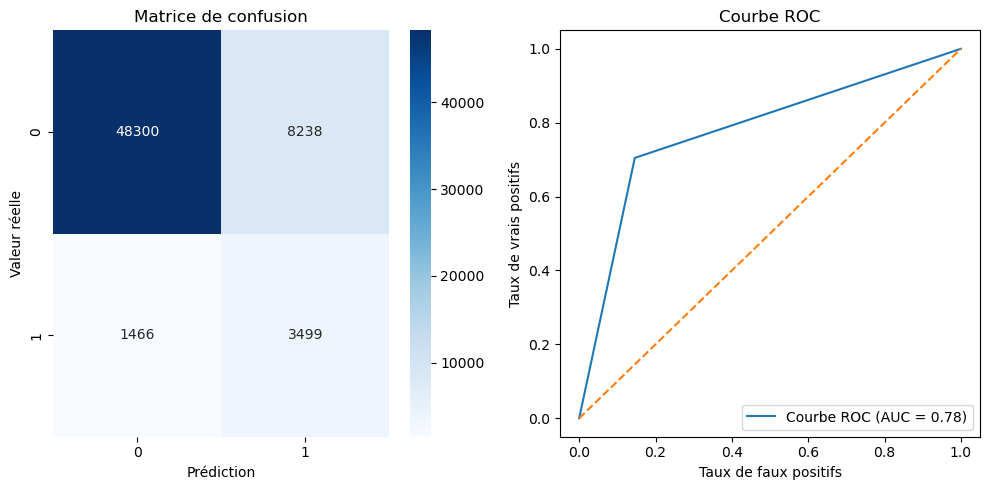

In [13]:
mlflow.set_experiment('Projet7-Modélisation')
start = time.time()
with mlflow.start_run(run_name='LightGBM feature selected paramétrée avec seuil') :
    model = lgb.LGBMClassifier(n_estimators = 515,max_depth = 6,learning_rate = 0.1,subsample = 0.9,colsample_bytree= 0.9 )
    model.fit(X_train_selected, y_train.values.ravel())
    # Convertir y_train en une série
    y_train_series = y_train.squeeze()
    y_pred = model.predict(X_train_selected)
    seuil_optimal = find_optimal_threshold(model, X_train_selected, y_train_series)

    print('seuil optimal : ',seuil_optimal)
    y_pred_train = predict_with_threshold(model, X_train_selected, seuil_optimal)
    y_pred = predict_with_threshold(model, X_test_selected, seuil_optimal)
    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'LightGBM feature selected paramétrée avec seuil')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )
    mlflow.log_param("n_estimator", 515)
    mlflow.log_param("Max_depth", 6)
    mlflow.log_param("Learning rate", 0.1)
    mlflow.log_param("Subsample", 0.9)
    mlflow.log_param("Colsample_bytree", 0.9)
    mlflow.log_param("Seuil", seuil_optimal)

In [14]:
# 4. Enregistrement du modèle et du seuil
model_with_threshold = {'model': model, 'threshold': seuil_optimal}
with open('LightGBM_with_threshold.pkl', 'wb') as f:
    pickle.dump(model_with_threshold, f)

In [29]:
pd.set_option('display.max_columns', None)
print(X_train_selected.columns.tolist())

['Nombredecrditsactifs', 'FLOORSMAXMODE', 'EXTSOURCE3', 'YEARSBEGINEXPLUATATIONMEDI', 'Nombredecrditsrembourss', 'EXTSOURCE2', 'OBS30CNTSOCIALCIRCLE', 'bureauMontantdesdettesactuelles', 'CODEGENDER', 'REGCITYNOTWORKCITY', 'NAMEFAMILYSTATUSMarried', 'DAYSBIRTH', 'FLAGOWNCAR', 'FLAGPHONE', 'REGIONRATINGCLIENTWCITY', 'NAMETYPESUITEUnaccompanied', 'YEARSBEGINEXPLUATATIONAVG', 'FLAGOWNREALTY', 'AMTANNUITY', 'ORGANIZATIONTYPESelfemployed', 'FLAGDOCUMENT3', 'bureauNombredejoursdepuisladerniredemande', 'AMTGOODSPRICE', 'NAMEINCOMETYPEWorking', 'AMTCREDIT', 'REGIONRATINGCLIENT', 'DAYSEMPLOYED', 'IPPaiementensouffrancemoyen', 'NAMEEDUCATIONTYPESecondarysecondaryspecial', 'DAYSREGISTRATION', 'YEARSBEGINEXPLUATATIONMODE', 'DAYSLASTPHONECHANGE', 'NAMECONTRACTTYPECashloans', 'CNTCHILDREN', 'TOTALAREAMODE', 'OCCUPATIONTYPELaborers', 'ORGANIZATIONTYPEBusinessEntityType3', 'REGCITYNOTLIVECITY', 'FLOORSMAXMEDI', 'NAMEEDUCATIONTYPEHighereducation', 'NAMEFAMILYSTATUSSinglenotmarried', 'DAYSIDPUBLISH', 'WE

In [7]:
# Enregistrement du feature engineering
Columns_selected = ['Nombredecrditsactifs', 'FLOORSMAXMODE', 'EXTSOURCE3', 'YEARSBEGINEXPLUATATIONMEDI',
                    'Nombredecrditsrembourss', 'EXTSOURCE2', 'OBS30CNTSOCIALCIRCLE', 'bureauMontantdesdettesactuelles',
                    'CODEGENDER', 'REGCITYNOTWORKCITY', 'NAMEFAMILYSTATUSMarried', 'DAYSBIRTH', 'FLAGOWNCAR', 'FLAGPHONE',
                    'REGIONRATINGCLIENTWCITY', 'NAMETYPESUITEUnaccompanied', 'YEARSBEGINEXPLUATATIONAVG', 'FLAGOWNREALTY',
                    'AMTANNUITY', 'ORGANIZATIONTYPESelfemployed', 'FLAGDOCUMENT3', 'bureauNombredejoursdepuisladerniredemande',
                    'AMTGOODSPRICE', 'NAMEINCOMETYPEWorking', 'AMTCREDIT', 'REGIONRATINGCLIENT', 'DAYSEMPLOYED',
                    'IPPaiementensouffrancemoyen', 'NAMEEDUCATIONTYPESecondarysecondaryspecial', 'DAYSREGISTRATION',
                    'YEARSBEGINEXPLUATATIONMODE', 'DAYSLASTPHONECHANGE', 'NAMECONTRACTTYPECashloans', 'CNTCHILDREN',
                    'TOTALAREAMODE', 'OCCUPATIONTYPELaborers', 'ORGANIZATIONTYPEBusinessEntityType3', 'REGCITYNOTLIVECITY',
                    'FLOORSMAXMEDI', 'NAMEEDUCATIONTYPEHighereducation', 'NAMEFAMILYSTATUSSinglenotmarried', 'DAYSIDPUBLISH',
                    'WEEKDAYAPPRPROCESSSTARTFRIDAY', 'OCCUPATIONTYPESalesstaff', 'WEEKDAYAPPRPROCESSSTARTTHURSDAY',
                    'FLAGDOCUMENT6', 'REGIONPOPULATIONRELATIVE', 'IPRetardmoyendespaiements', 'OCCUPATIONTYPECorestaff', 
                    'OCCUPATIONTYPEDrivers', 'WEEKDAYAPPRPROCESSSTARTMONDAY', 'LIVEREGIONNOTWORKREGION', 'FLAGEMAIL',
                    'FLOORSMAXAVG', 'bureauMontantcrditsencours', 'ORGANIZATIONTYPESchool', 'HOURAPPRPROCESSSTART', 
                    'AMTINCOMETOTAL', 'WEEKDAYAPPRPROCESSSTARTWEDNESDAY', 'DEF30CNTSOCIALCIRCLE', 
                    'ORGANIZATIONTYPETransporttype3', 'FLAGWORKPHONE', 'OCCUPATIONTYPESecuritystaff',
                    'LIVECITYNOTWORKCITY', 'WEEKDAYAPPRPROCESSSTARTTUESDAY', 'NAMEHOUSINGTYPEHouseapartment',
                    'PreviousMontantdemandmoyen', 'ORGANIZATIONTYPETradetype7', 'ORGANIZATIONTYPEAgriculture',
                    'WEEKDAYAPPRPROCESSSTARTSATURDAY', 'NAMETYPESUITEFamily', 'FLAGEMPPHONE', 'CNTFAMMEMBERS',
                    'NAMEFAMILYSTATUSSeparated', 'NAMEINCOMETYPEStateservant', 'ORGANIZATIONTYPEOther',
                    'NAMEHOUSINGTYPEMunicipalapartment', 'DEF60CNTSOCIALCIRCLE', 'OBS60CNTSOCIALCIRCLE', 
                    'OCCUPATIONTYPEHighskilltechstaff', 'NAMEFAMILYSTATUSWidow']

X_train_selected = X_train[Columns_selected]
X_test_selected = X_test[Columns_selected]

In [12]:
X_train_selected.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_X_train_selected_LGBM.csv')
X_test_selected.to_csv(r'C:\Users\Jérôme\Desktop\DataZ\P7_X_test_selected_LGBM.csv')

# XGBoost

temps d execution :  57.36565446853638
accuracy train : 0.97
accuracy test: 0.93
AUC: 0.6068254498030841
Score métier test :  390.8


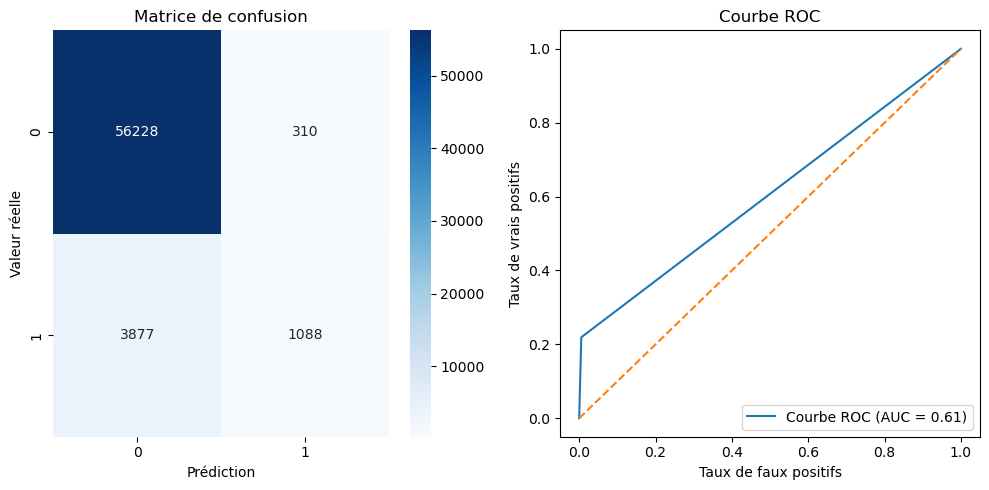

In [38]:
X_train = X_train_scaled_df.copy()
X_test = X_test_scaled_df.copy()
mlflow.set_experiment('Projet7-Modélisation')
start = time.time()
with mlflow.start_run(run_name='XGBoost') :
    # Création du modèle XGBoost
    model = XGBClassifier()

    # Définition de la fonction de coût personnalisée comme la métrique à minimiser
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'XGBoost')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )

In [39]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
# Obtention des importances des fonctionnalités
importances = model.feature_importances_

# Création d'un DataFrame pour stocker les noms de colonnes et les importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Tri du DataFrame selon les importances
sorted_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Affichage des noms de colonnes et des importances
print(sorted_importances)

                                               Feature  Importance
150                        OCCUPATION_TYPE_Sales staff    0.059875
0                                          CODE_GENDER    0.057207
187  NAME_EDUCATION_TYPE_Secondary / secondary special    0.053801
173                           NAME_INCOME_TYPE_Working    0.052427
44                                     FLAG_DOCUMENT_3    0.052323
134                 WEEKDAY_APPR_PROCESS_START_TUESDAY    0.044114
2                                      FLAG_OWN_REALTY    0.044024
3                                         CNT_CHILDREN    0.041483
38                            OBS_30_CNT_SOCIAL_CIRCLE    0.037440
161                         NAME_FAMILY_STATUS_Married    0.034584
47                                     FLAG_DOCUMENT_6    0.033905
17                                          FLAG_PHONE    0.032693
27                              REG_CITY_NOT_WORK_CITY    0.031687
180                      NAME_TYPE_SUITE_Unaccompanied    0.02

In [40]:

# Créer une série pandas avec les noms de colonnes et leurs importances
feature_importances = pd.Series(importances, index=X_train.columns)

# Trier les fonctionnalités par ordre décroissant d'importance
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Afficher les noms de colonnes et leurs importances
print(sorted_feature_importances)

# Définir un seuil d'importance (à ajuster en fonction de vos besoins)
threshold = 0.0001

# Sélectionner les colonnes dont l'importance est supérieure ou égale au seuil
selected_columns = sorted_feature_importances[sorted_feature_importances >= threshold].index

# Supprimer les colonnes non sélectionnées de vos données
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]
print(X_train_selected.columns)

OCCUPATION_TYPE_Sales staff                            0.059875
CODE_GENDER                                            0.057207
NAME_EDUCATION_TYPE_Secondary / secondary special      0.053801
NAME_INCOME_TYPE_Working                               0.052427
FLAG_DOCUMENT_3                                        0.052323
WEEKDAY_APPR_PROCESS_START_TUESDAY                     0.044114
FLAG_OWN_REALTY                                        0.044024
CNT_CHILDREN                                           0.041483
OBS_30_CNT_SOCIAL_CIRCLE                               0.037440
NAME_FAMILY_STATUS_Married                             0.034584
FLAG_DOCUMENT_6                                        0.033905
FLAG_PHONE                                             0.032693
REG_CITY_NOT_WORK_CITY                                 0.031687
NAME_TYPE_SUITE_Unaccompanied                          0.029511
REGION_RATING_CLIENT                                   0.028852
FLAG_OWN_CAR                            

temps d execution :  49.89142155647278
accuracy train : 0.97
accuracy test: 0.93
AUC: 0.6063518811880553
Score métier test :  391.28


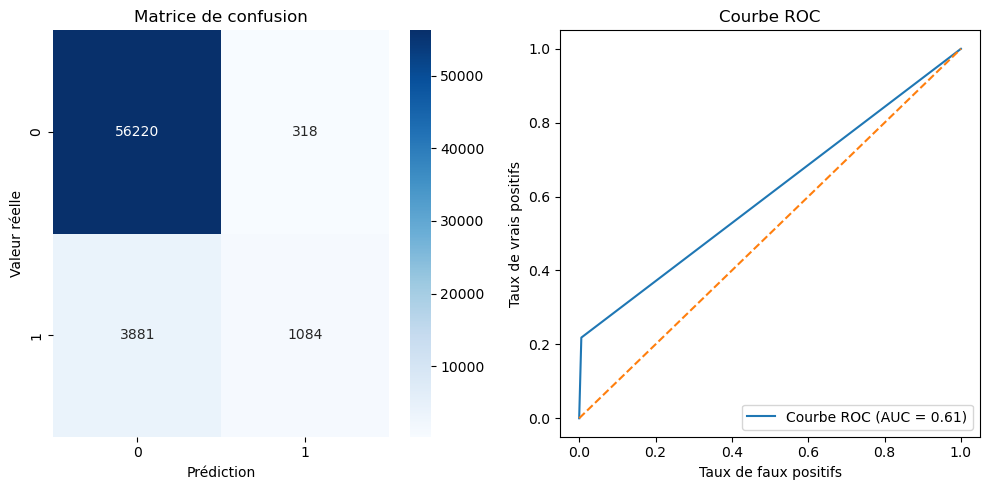

In [41]:
mlflow.set_experiment('Projet7-Modélisation')
start = time.time()
with mlflow.start_run(run_name='XGBoost feature selected') :
    # Création du modèle XGBoost
    model = XGBClassifier()

    # Définition de la fonction de coût personnalisée comme la métrique à minimiser
    model.fit(X_train_selected, y_train)
    y_pred_train = model.predict(X_train_selected)
    y_pred = model.predict(X_test_selected)

    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'XGBoost feature selected')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )

In [42]:
# Définir les hyperparamètres et leurs distributions à échantillonner
param_dist = {'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [100, 200, 500],
              'max_depth': [3, 5, 10]}

# Créer le modèle XGBoost
model = XGBClassifier()

# Créer l'objet RandomizedSearchCV avec votre fonction de coût personnalisée
random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring = custom_scorer, cv=5, n_iter=5)

# Effectuer la recherche aléatoire des meilleurs paramètres
random_search.fit(X_train_selected, y_train)

# Obtenir les meilleurs paramètres et le meilleur score
best_params = random_search.best_params_
best_score = random_search.best_score_
print('Meilleurs paramètres : ', best_params)
print('Meilleur score : ', best_score)

# Affichage des résultats par fold
cv_results = random_search.cv_results_
for fold_idx, mean_score, params in zip(cv_results['split0_test_score'], cv_results['mean_test_score'], cv_results['params']):
    print("Fold:", fold_idx)
    print("Mean Score:", mean_score)
    print("Parameters:", params)
    print()

Meilleurs paramètres :  {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1}
Meilleur score :  -402.04200000000003
Fold: -2007.7
Mean Score: -439.602
Parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01}

Fold: -1985.9
Mean Score: -404.2900000000001
Parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 1}

Fold: -1986.0
Mean Score: -407.124
Parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 1}

Fold: -1987.0
Mean Score: -402.04200000000003
Parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1}

Fold: -1986.0
Mean Score: -408.124
Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 1}



temps d execution :  119.88892316818237
accuracy train : 0.96
accuracy test: 0.93
AUC: 0.5662247961133859
Score métier test :  430.98


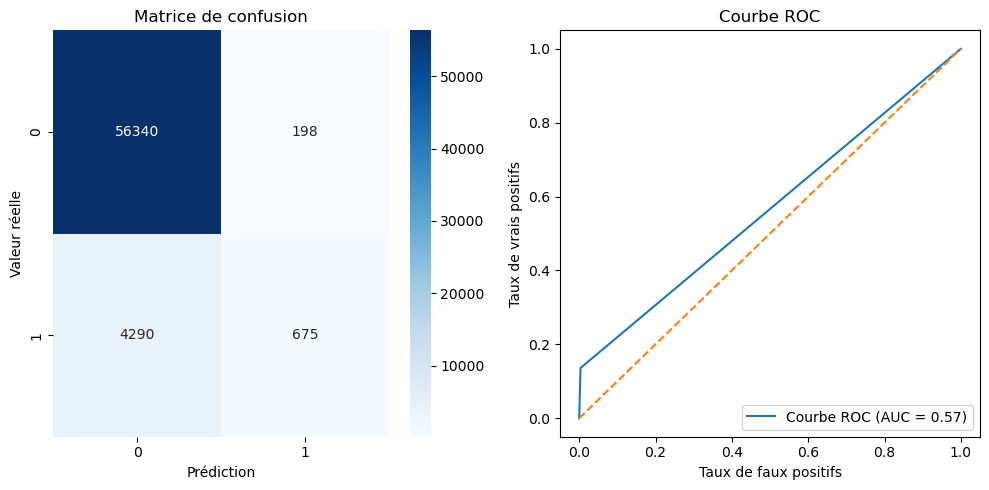

In [43]:
mlflow.set_experiment('Projet7-Modélisation')
start = time.time()
with mlflow.start_run(run_name='XGBoost feature selected paramétrée') :
    # Création du modèle XGBoost
    model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 3 )

    # Définition de la fonction de coût personnalisée comme la métrique à minimiser
    model.fit(X_train_selected, y_train)
    y_pred_train = model.predict(X_train_selected)
    y_pred = model.predict(X_test_selected)

    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'XGBoost feature selected paramétrée')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )
    mlflow.log_param("n_estimator", 500)
    mlflow.log_param("Max_depth", 3)
    mlflow.log_param("Learning rate", 0.1)

In [44]:
pd.set_option('display.max_columns', None)
print(X_train_selected.columns.tolist())

['OCCUPATION_TYPE_Sales staff', 'CODE_GENDER', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_INCOME_TYPE_Working', 'FLAG_DOCUMENT_3', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'OBS_30_CNT_SOCIAL_CIRCLE', 'NAME_FAMILY_STATUS_Married', 'FLAG_DOCUMENT_6', 'FLAG_PHONE', 'REG_CITY_NOT_WORK_CITY', 'NAME_TYPE_SUITE_Unaccompanied', 'REGION_RATING_CLIENT', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE_Higher education', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'OCCUPATION_TYPE_Drivers', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_3', 'ORGANIZATION_TYPE_Business Entity Type 3', 'OCCUPATION_TYPE_Laborers', 'ORGANIZATION_TYPE_Self-employed', 'OCCUPATION_TYPE_Core staff', 'FLAG_WORK_PHONE', 'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'NAME_CONTRACT_TYPE_Cash loans', 'IP - Paiement en souffrance moyen', 'EXT_SOURCE_2', 'Nombre de crédits acti

In [46]:
# Enregistrement du feature engineering
Columns_selected = ['OCCUPATION_TYPE_Sales staff', 'CODE_GENDER', 'NAME_EDUCATION_TYPE_Secondary / secondary special',
        'NAME_INCOME_TYPE_Working', 'FLAG_DOCUMENT_3', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'FLAG_OWN_REALTY',
        'CNT_CHILDREN', 'OBS_30_CNT_SOCIAL_CIRCLE', 'NAME_FAMILY_STATUS_Married', 'FLAG_DOCUMENT_6', 'FLAG_PHONE',
        'REG_CITY_NOT_WORK_CITY', 'NAME_TYPE_SUITE_Unaccompanied', 'REGION_RATING_CLIENT', 'FLAG_OWN_CAR', 
        'NAME_EDUCATION_TYPE_Higher education', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
        'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
        'OCCUPATION_TYPE_Drivers', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_3', 'ORGANIZATION_TYPE_Business Entity Type 3',
        'OCCUPATION_TYPE_Laborers', 'ORGANIZATION_TYPE_Self-employed', 'OCCUPATION_TYPE_Core staff', 'FLAG_WORK_PHONE',
        'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'NAME_CONTRACT_TYPE_Cash loans', 'IP - Paiement en souffrance moyen',
        'EXT_SOURCE_2', 'Nombre de crédits actifs', 'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY', 
        'DEF_30_CNT_SOCIAL_CIRCLE', 'FLOORSMAX_MODE', 'FLAG_EMP_PHONE', 'NAME_FAMILY_STATUS_Single / not married',
        'FLAG_EMAIL', 'Nombre de crédits remboursés', 'ORGANIZATION_TYPE_School', 'DEF_60_CNT_SOCIAL_CIRCLE',
        'YEARS_BEGINEXPLUATATION_MEDI', 'LIVE_REGION_NOT_WORK_REGION', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 
        'bureau - Montant des dettes actuelles', 'OCCUPATION_TYPE_High skill tech staff', 'AMT_GOODS_PRICE', 
        'bureau - Nombre de jours depuis la dernière demande', 'ORGANIZATION_TYPE_Trade: type 7', 
        'NAME_INCOME_TYPE_Commercial associate', 'OCCUPATION_TYPE_Security staff', 'YEARS_BEGINEXPLUATATION_AVG',
        'ORGANIZATION_TYPE_Military', 'AMT_ANNUITY', 'NAME_EDUCATION_TYPE_Lower secondary', 
        'ORGANIZATION_TYPE_Transport: type 3', 'NAME_HOUSING_TYPE_Municipal apartment', 'HOUR_APPR_PROCESS_START', 
        'AMT_CREDIT', 'NAME_TYPE_SUITE_Family', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ORGANIZATION_TYPE_Telecom', 'FLOORSMAX_MEDI',
        'NAME_HOUSING_TYPE_Office apartment', 'ORGANIZATION_TYPE_Agriculture', 'REG_REGION_NOT_WORK_REGION',
        'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Civil marriage', 'YEARS_BEGINEXPLUATATION_MODE', 
        'OCCUPATION_TYPE_Accountants', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_Legal Services', 
        'ORGANIZATION_TYPE_Kindergarten', 'ORGANIZATION_TYPE_Hotel', 'NAME_HOUSING_TYPE_Rented apartment', 
        'FLOORSMAX_AVG', 'FLAG_DOCUMENT_8', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Emergency',
        'ORGANIZATION_TYPE_Restaurant', 'REGION_POPULATION_RELATIVE', 'DAYS_LAST_PHONE_CHANGE', 'TOTALAREA_MODE',
        'ORGANIZATION_TYPE_Realtor', 'FLAG_DOCUMENT_5', 'ORGANIZATION_TYPE_Trade: type 3', 'DAYS_REGISTRATION',
        'ORGANIZATION_TYPE_Housing', 'OBS_60_CNT_SOCIAL_CIRCLE', 'NAME_HOUSING_TYPE_House / apartment',
        'ORGANIZATION_TYPE_Trade: type 2', 'ORGANIZATION_TYPE_Postal', 'FLAG_DOCUMENT_15', 'REG_REGION_NOT_LIVE_REGION',
        'ORGANIZATION_TYPE_Trade: type 6', 'ORGANIZATION_TYPE_Industry: type 9', 'OCCUPATION_TYPE_Cleaning staff',
        'bureau - Montant crédits en cours', 'AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE_Children', 'OCCUPATION_TYPE_Cooking staff',
        'ORGANIZATION_TYPE_Industry: type 4', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_18', 'NAME_HOUSING_TYPE_With parents',
        'ORGANIZATION_TYPE_Transport: type 1', 'Previous - Montant demandé moyen', 'IP - Retard moyen des paiements',
        'DAYS_ID_PUBLISH', 'ORGANIZATION_TYPE_Transport: type 2', 'ORGANIZATION_TYPE_Transport: type 4',
        'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Incomplete higher', 'ORGANIZATION_TYPE_Other',
        'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Secretaries', 'NAME_INCOME_TYPE_State servant',
        'ORGANIZATION_TYPE_Security', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Medicine',
        'ORGANIZATION_TYPE_Industry: type 3', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Realty agents',
        'ORGANIZATION_TYPE_Police', 'ORGANIZATION_TYPE_Business Entity Type 1',
        'NAME_FAMILY_STATUS_Widow', 'FLAG_DOCUMENT_9']

X_train_selected = X_train[Columns_selected]
X_test_selected = X_test[Columns_selected]

In [48]:
# Recherche du seuil optimal
model = XGBClassifier()
model.fit(X_train_selected, y_train)
# Convertir y_train en une série
y_train_series = y_train.squeeze()

seuil_optimal = find_optimal_threshold(model, X_train_selected, y_train_series)
print('seuil optimal : ',seuil_optimal)

seuil optimal :  0.11


accuracy train : 0.92
accuracy test: 0.83
AUC: 0.7638746188831745
Score métier test :  245.04


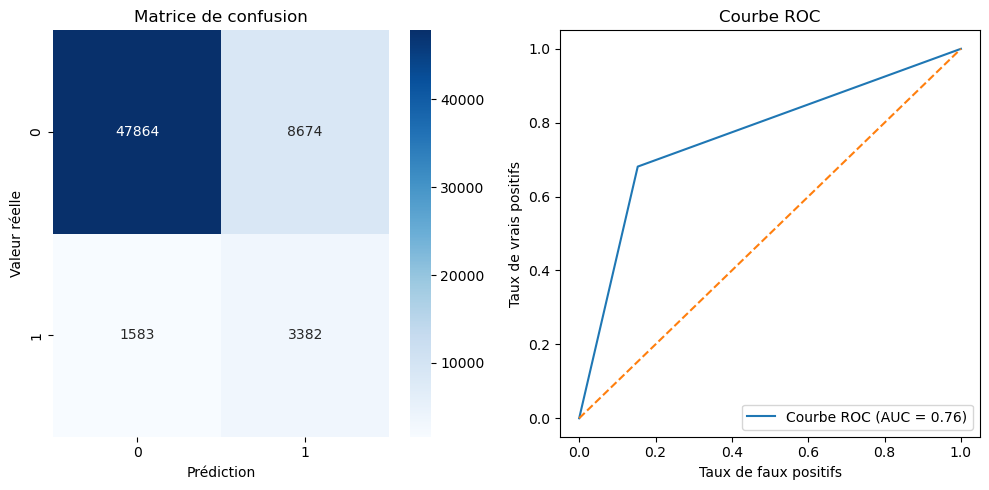

In [49]:
y_pred_train = predict_with_threshold(model, X_train_selected, seuil_optimal)
y_pred = predict_with_threshold(model, X_test_selected, seuil_optimal)
print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
plot_confusion_roc(y_test, y_pred)


seuil optimal :  0.12
temps d execution :  231.3944435119629
accuracy train : 0.93
accuracy test: 0.85
AUC: 0.7722977215334894
Score métier test :  235.46


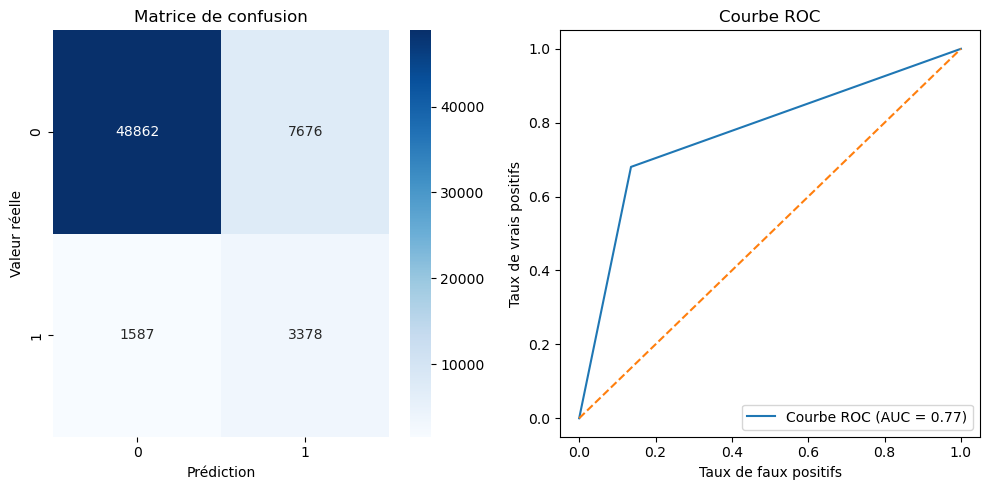

In [52]:
mlflow.set_experiment('Projet7-Modélisation')
start = time.time()
with mlflow.start_run(run_name='XGBoost feature selected paramétrée avec seuil') :
    model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 5)
    model.fit(X_train_selected, y_train)
    # Convertir y_train en une série
    y_train_series = y_train.squeeze()
    y_pred = model.predict(X_train_selected)
    seuil_optimal = find_optimal_threshold(model, X_train_selected, y_train_series)

    print('seuil optimal : ',seuil_optimal)
    y_pred_train = predict_with_threshold(model, X_train_selected, seuil_optimal)
    y_pred = predict_with_threshold(model, X_test_selected, seuil_optimal)
    End = time.time()
    print('temps d execution : ',End - start)
    print('accuracy train :', round(metrics.accuracy_score(y_train, y_pred_train), 2))
    plot_confusion_roc(y_test, y_pred)
    mlflow.sklearn.log_model(model, 'XGBoost feature selected paramétrée avec seuil')
    mlflow.log_metric('accuracy_train',round(metrics.accuracy_score(y_train, y_pred_train),2) )
    mlflow.log_metric('accuracy_test',round(metrics.accuracy_score(y_test, y_pred),2) )
    mlflow.log_metric('score métier',round(custom_cost(y_test, y_pred),2) )
    mlflow.log_param("n_estimator", 500)
    mlflow.log_param("Max_depth", 5)
    mlflow.log_param("Learning rate", 0.1)
    mlflow.log_param("Seuil", seuil_optimal)

In [51]:
# 4. Enregistrement du modèle et du seuil
model_with_threshold = {'model': model, 'threshold': seuil_optimal}
with open('XGBoost_with_threshold.pkl', 'wb') as f:
    pickle.dump(model_with_threshold, f)

# Synthèse des résultats

In [63]:

data = {
    'Model': ['Dummy Classifier', 'Régression logistique', 'LightGBM','LightGBM optimisé','XGBoost','XGBoost optimisé'],
    'Temps exécution':   [0.019, 79.07 , 73.6  ,47.36 ,155.65 ,185.72],
    'Accuracy train':    [0.5  , 0.72  , 0.96  ,0.93  , 0.97  ,0.93],
    'Accuracy test':     [0.92 , 0.71  , 0.93  ,0.84  ,0.93   ,0.85],
    'AUC':               [0.5  , 0.70  , 0.55  ,0.78  , 0.60  ,0.77],
    'Score métier test': [496.5, 318.12, 441.91,227.7 ,392.91 ,235.46]
}

# Création du DataFrame
df = pd.DataFrame(data)

# Affichage du DataFrame
df.head(10)


,Model,Temps exécution,Accuracy train,Accuracy test,AUC,Score métier test
0,Dummy Classifier,0.019,0.50,0.92,0.50,496.50
1,Régression logistique,79.070,0.72,0.71,0.70,318.12
2,LightGBM,73.600,0.96,0.93,0.55,441.91
3,LightGBM optimisé,47.360,0.93,0.84,0.78,227.70
4,XGBoost,155.650,0.97,0.93,0.60,392.91
5,XGBoost optimisé,185.720,0.93,0.85,0.77,235.46


# Feature importance

### Globale

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


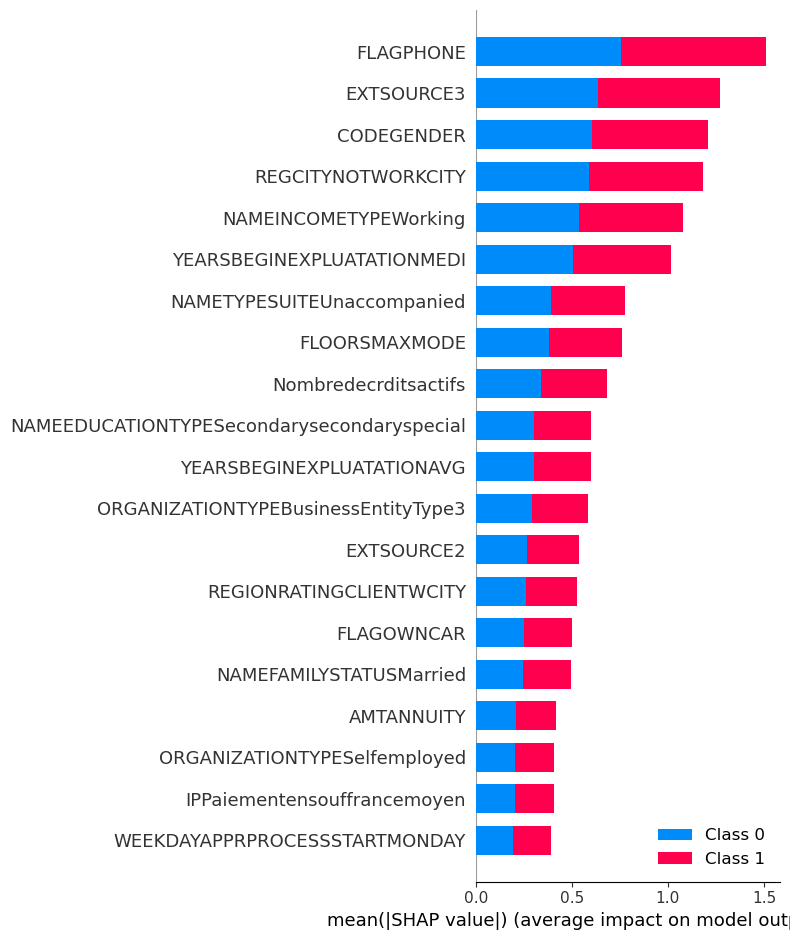

In [27]:
# Créer un explainer SHAP avec le modèle entraîné
explainer = shap.Explainer(model)

# Calculer les valeurs SHAP pour les données d'entrée
shap_values = explainer.shap_values(X_test_selected)

# Générer le graphique d'importance globale des features
shap.summary_plot(shap_values, X_test_selected, plot_type='bar')

# Afficher le graphique
plt.show()


### Locale

In [5]:
# Import du modèle et du seuil optimal définis précédemment
with open('LightGBM_with_threshold.pkl', 'rb') as f:
    model_with_threshold = pickle.load(f)

model = model_with_threshold['model']
seuil_optimal = model_with_threshold['threshold']

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Prédiction: 0.0
Prédiction seuillée: False
Valeurs SHAP: [array([[ 2.91900680e-02,  9.81150894e-01, -2.93316513e-01,
         1.01757835e-01,  5.94141377e-02,  1.39968639e-01,
         1.87257606e-01,  1.01571040e-01,  3.47604081e-01,
         3.98812725e-01,  1.88470802e-01, -9.98723907e-02,
         3.39763590e-01,  7.53538084e-01,  2.52439564e-01,
         2.88979904e-01,  5.55571389e-01,  1.32712878e-01,
        -1.30295177e-01,  2.06181097e-01,  4.19490611e-01,
         1.44394143e-02,  3.26680633e-01,  6.36815644e-01,
         1.07050669e-02,  1.53006801e-01, -1.56220121e-01,
         1.46610912e-01,  7.39307492e-01, -9.12007342e-02,
        -3.27678286e-01, -1.07414696e-01,  3.39174184e-03,
         1.32059920e-01, -1.27099282e-02,  6.61439957e-02,
         3.11480278e-01,  1.04264232e-01,  1.54711011e-01,
         4.40004221e-02,  1.18457717e-01,  2.23169397e-02,
         1.47332472e-01,  1.74816862e-02,  4.32636393e-02,
         3.86439734e-02, -3.59772122e-02,  7.57705776e-02

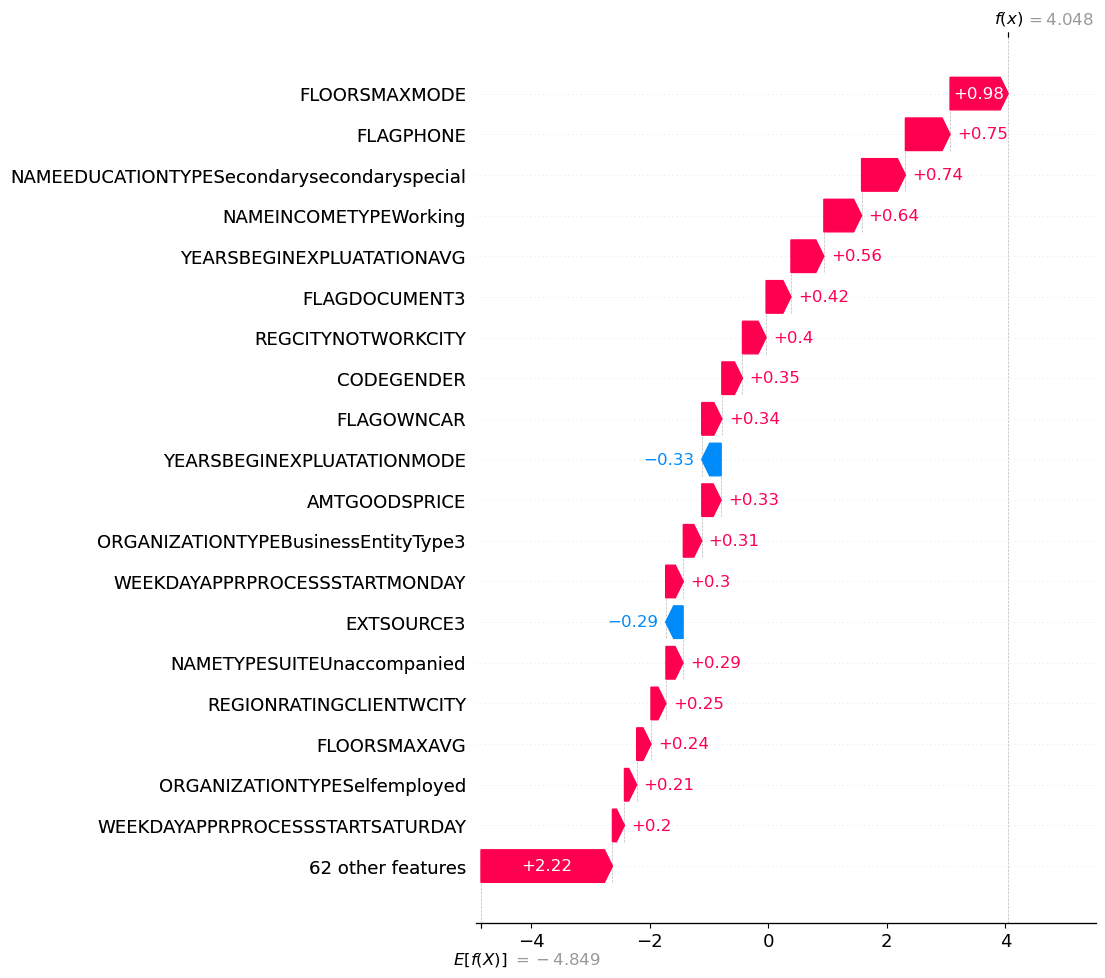

In [26]:
# Créer un explainer SHAP avec le modèle entraîné
explainer = shap.Explainer(model)

# Sélectionner la première ligne de X_test_selected
first_row = X_test_selected.iloc[0]

# Convertir la première ligne en un tableau numpy
data = np.array([first_row])

# Calculer les valeurs SHAP pour les données d'entrée
shap_values = explainer.shap_values(data)

# Afficher la prédiction et les valeurs SHAP
prediction = model.predict(data)
prediction_thresholded = prediction >= seuil_optimal
print("Prédiction:", prediction[0])
print("Prédiction seuillée:", prediction_thresholded[0])
print("Valeurs SHAP:", shap_values)

# Obtener les noms des features
feature_names = X_test_selected.columns.tolist()

# Générer le graphique waterfall
expected_value = explainer.expected_value[0]
shap.waterfall_plot(
    shap.Explanation(values=shap_values[0][0], base_values=expected_value, feature_names=feature_names),
    max_display=20
)

# Afficher le graphique
plt.show()
